# Supervised Machine Learning Project

You are provided hourly rental data spanning two years. 

For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. 

You must predict the `total count` of bikes rented during each hour covered by the test set, using only information available prior to the rental period.



## Importing libraries

In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.dummy import DummyRegressor

In [370]:
sns.set_style('whitegrid')


# Loading the data

In [459]:
path = "/Users/axelreman/Documents/Nod Coding Bootcamp/Projects/Project_5_Supervised_ML/bike-sharing-demand/"

df = pd.read_csv(f'{path}train.csv')

- datetime - hourly date + timestamp  

- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

- holiday - whether the day is considered a holiday

- workingday - whether the day is neither a weekend nor holiday

- _***weather***_
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 

    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 

    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 

    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

- temp - temperature in Celsius

- atemp - "feels like" temperature in Celsius

- humidity - relative humidity

- windspeed - wind speed

- casual - number of non-registered user rentals initiated

- registered - number of registered user rentals initiated

- count - number of total rentals

In [460]:
df

datetime  season  holiday  workingday  weather   temp   
0      2011-01-01 00:00:00       1        0           0        1   9.84  \
1      2011-01-01 01:00:00       1        0           0        1   9.02   
2      2011-01-01 02:00:00       1        0           0        1   9.02   
3      2011-01-01 03:00:00       1        0           0        1   9.84   
4      2011-01-01 04:00:00       1        0           0        1   9.84   
...                    ...     ...      ...         ...      ...    ...   
10881  2012-12-19 19:00:00       4        0           1        1  15.58   
10882  2012-12-19 20:00:00       4        0           1        1  14.76   
10883  2012-12-19 21:00:00       4        0           1        1  13.94   
10884  2012-12-19 22:00:00       4        0           1        1  13.94   
10885  2012-12-19 23:00:00       4        0           1        1  13.12   

        atemp  humidity  windspeed  casual  registered  count  
0      14.395        81     0.0000       3          13     16  
1      13.635        80     0.0000       8          32     40  
2      13.635        80     0.0000       5          27     32  
3      14.395        75     0.0000       3          10     13  
4      14.395        75     0.0000       0           1      1  
...       ...       ...        ...     ...         ...    ...  
10881  19.695        50    26.0027       7         329    336  
10882  17.425        57    15.0013      10         231    241  
10883  15.910        61    15.0013       4         164    168  
10884  17.425        61     6.0032      12         117    129  
10885  16.665        66     8.9981       4          84     88  

[10886 rows x 12 columns]

In [374]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [375]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [463]:
df['datetime'] = pd.to_datetime(df['datetime'])
datetime = pd.DatetimeIndex(df['datetime'])

df['hour'] = datetime.hour
df['dow'] = datetime.dayofweek
df['month'] = datetime.month



In [466]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'dow', 'month'],
      dtype='object')

In [539]:
df.loc[df['season']=='fall']['month'].value_counts()

month
7    912
8    912
9    909
Name: count, dtype: int64

In [468]:
df.drop(columns='datetime', inplace=True)

In [469]:
season_mapper = {1: 'spring', 2:'summer', 3:'fall', 4:'winter'}
weather_mapper = {1: 'Clear', 2:'Cloudy', 3:'Wet', 4:'Storms'}
work_mapper = {0: 'no', 1:'yes'}
weekday_mapper = {0:'monday', 1:'tuesday', 2:'wednesday', 3:'thursday', 4:'friday', 5:'saturday', 6:'sunday'}

df['season'] = df.season.map(season_mapper)
df['weather'] = df.weather.map(weather_mapper)
df['holiday'] = df.holiday.map(work_mapper)
df['workingday'] = df.workingday.map(work_mapper)
df['dow'] = df.dow.map(weekday_mapper)

In [470]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour', 'dow',
       'month'],
      dtype='object')

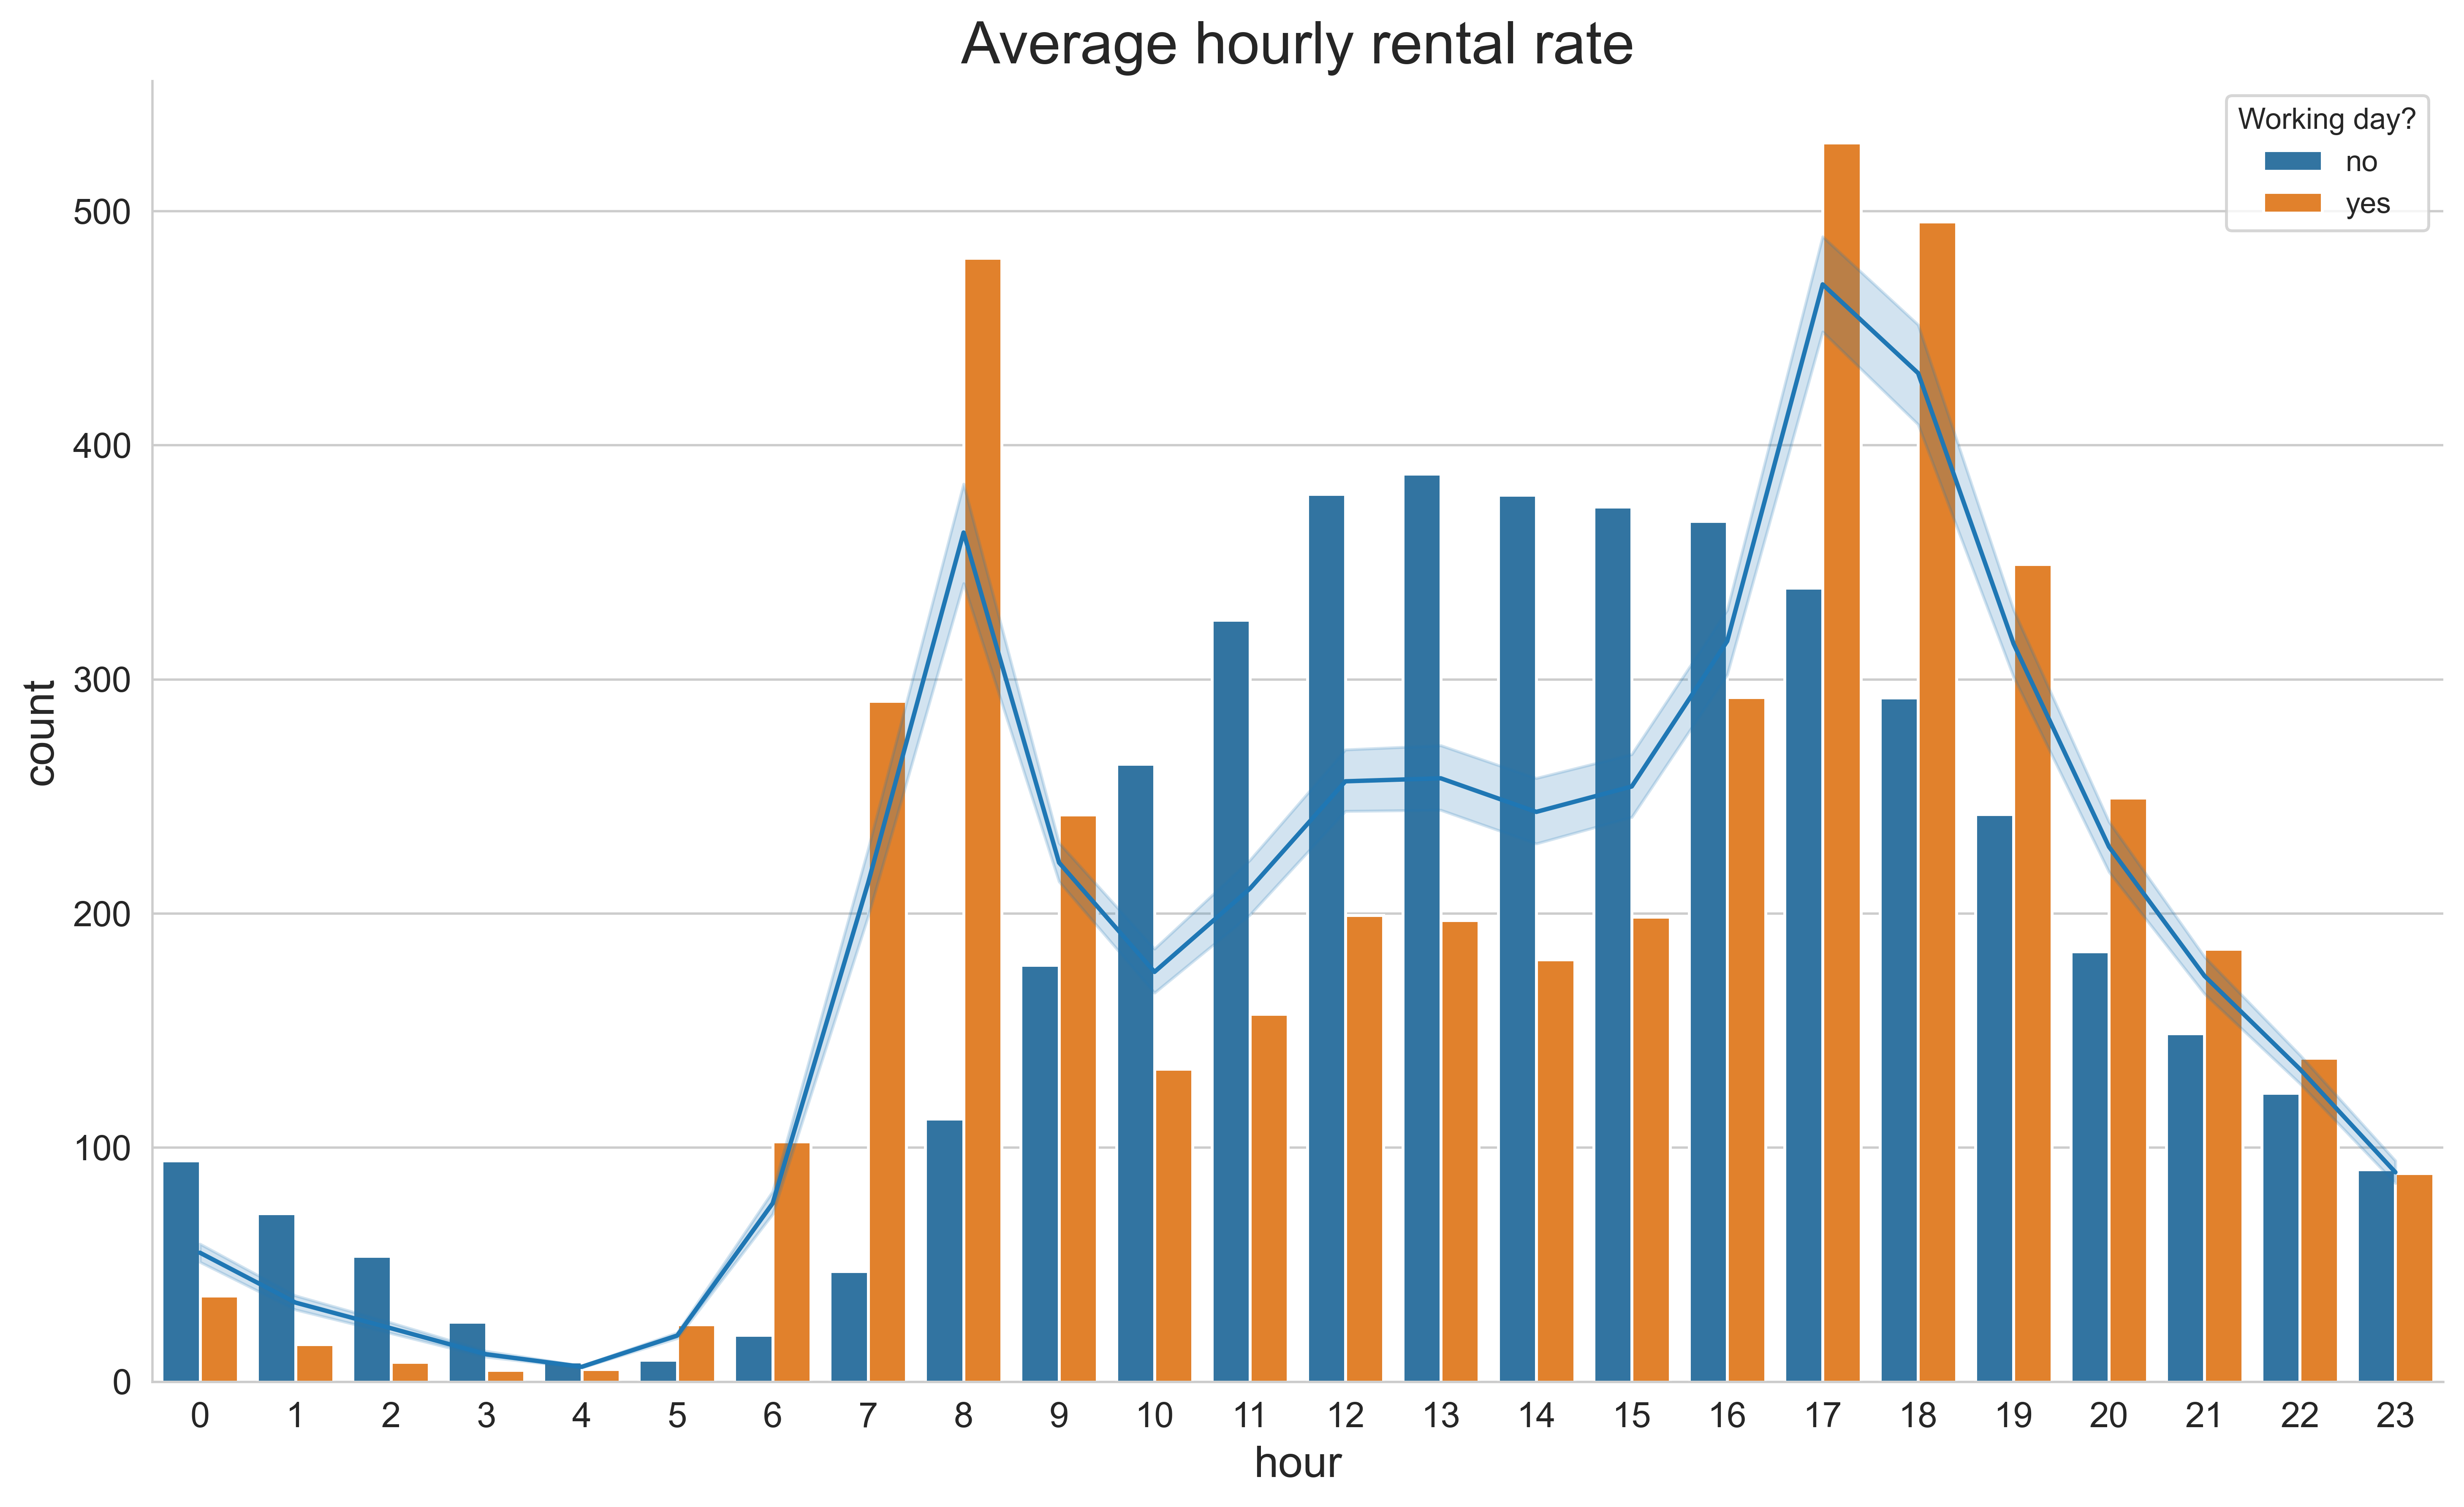

In [577]:
plt.figure(figsize=(14, 8), dpi=500)
plt.title('Average hourly rental rate', fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Number of passengers", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,23)
sns.barplot(data=df, x='hour', y='count',estimator='mean', errorbar=None, hue='workingday')
sns.lineplot(data=df, x='hour', y='count',estimator='mean')
plt.legend(title='Working day?')
sns.despine()

plt.savefig(fname='AvgHourlyRentalRateOverall', transparent=True)

plt.show()

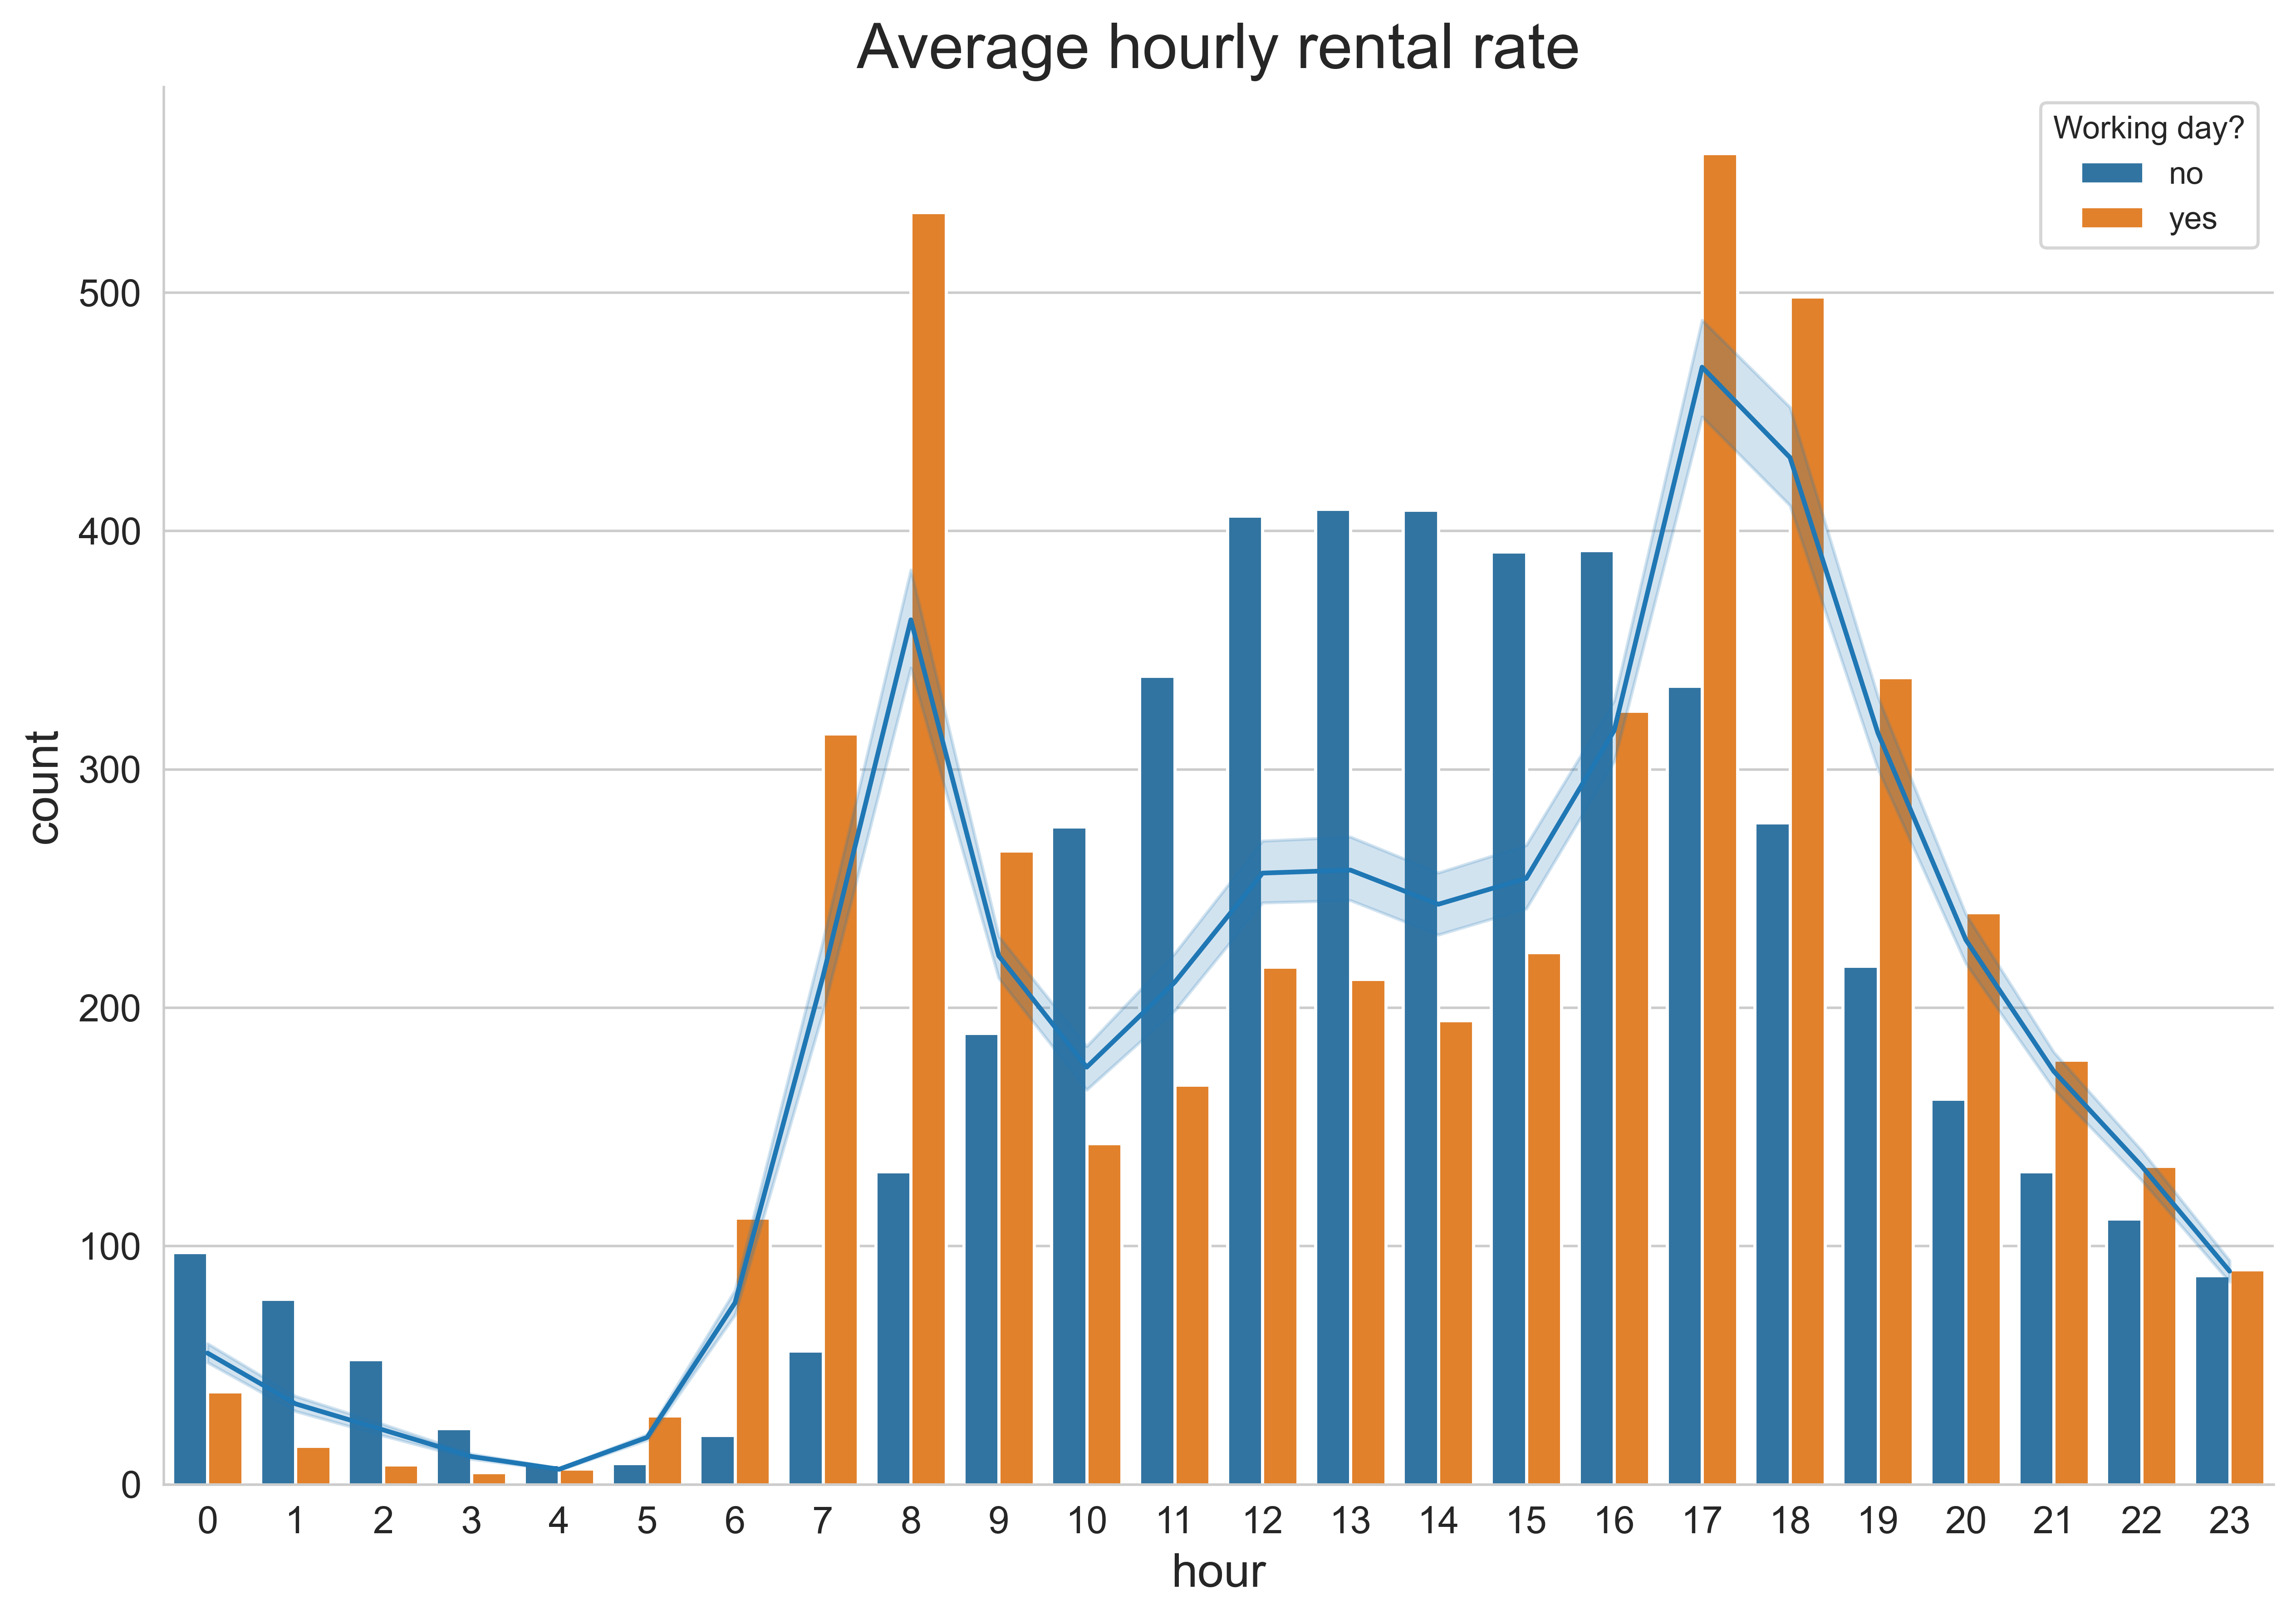

In [550]:
plt.figure(figsize=(12, 8), dpi=500)
plt.title('Average hourly rental rate', fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Number of passengers", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,23)
sns.barplot(data=df.loc[df['season']=='winter'], x='hour', y='count',estimator='mean', errorbar=None, hue='workingday')
sns.lineplot(data=df, x='hour', y='count')
plt.legend(title='Working day?')
sns.despine()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


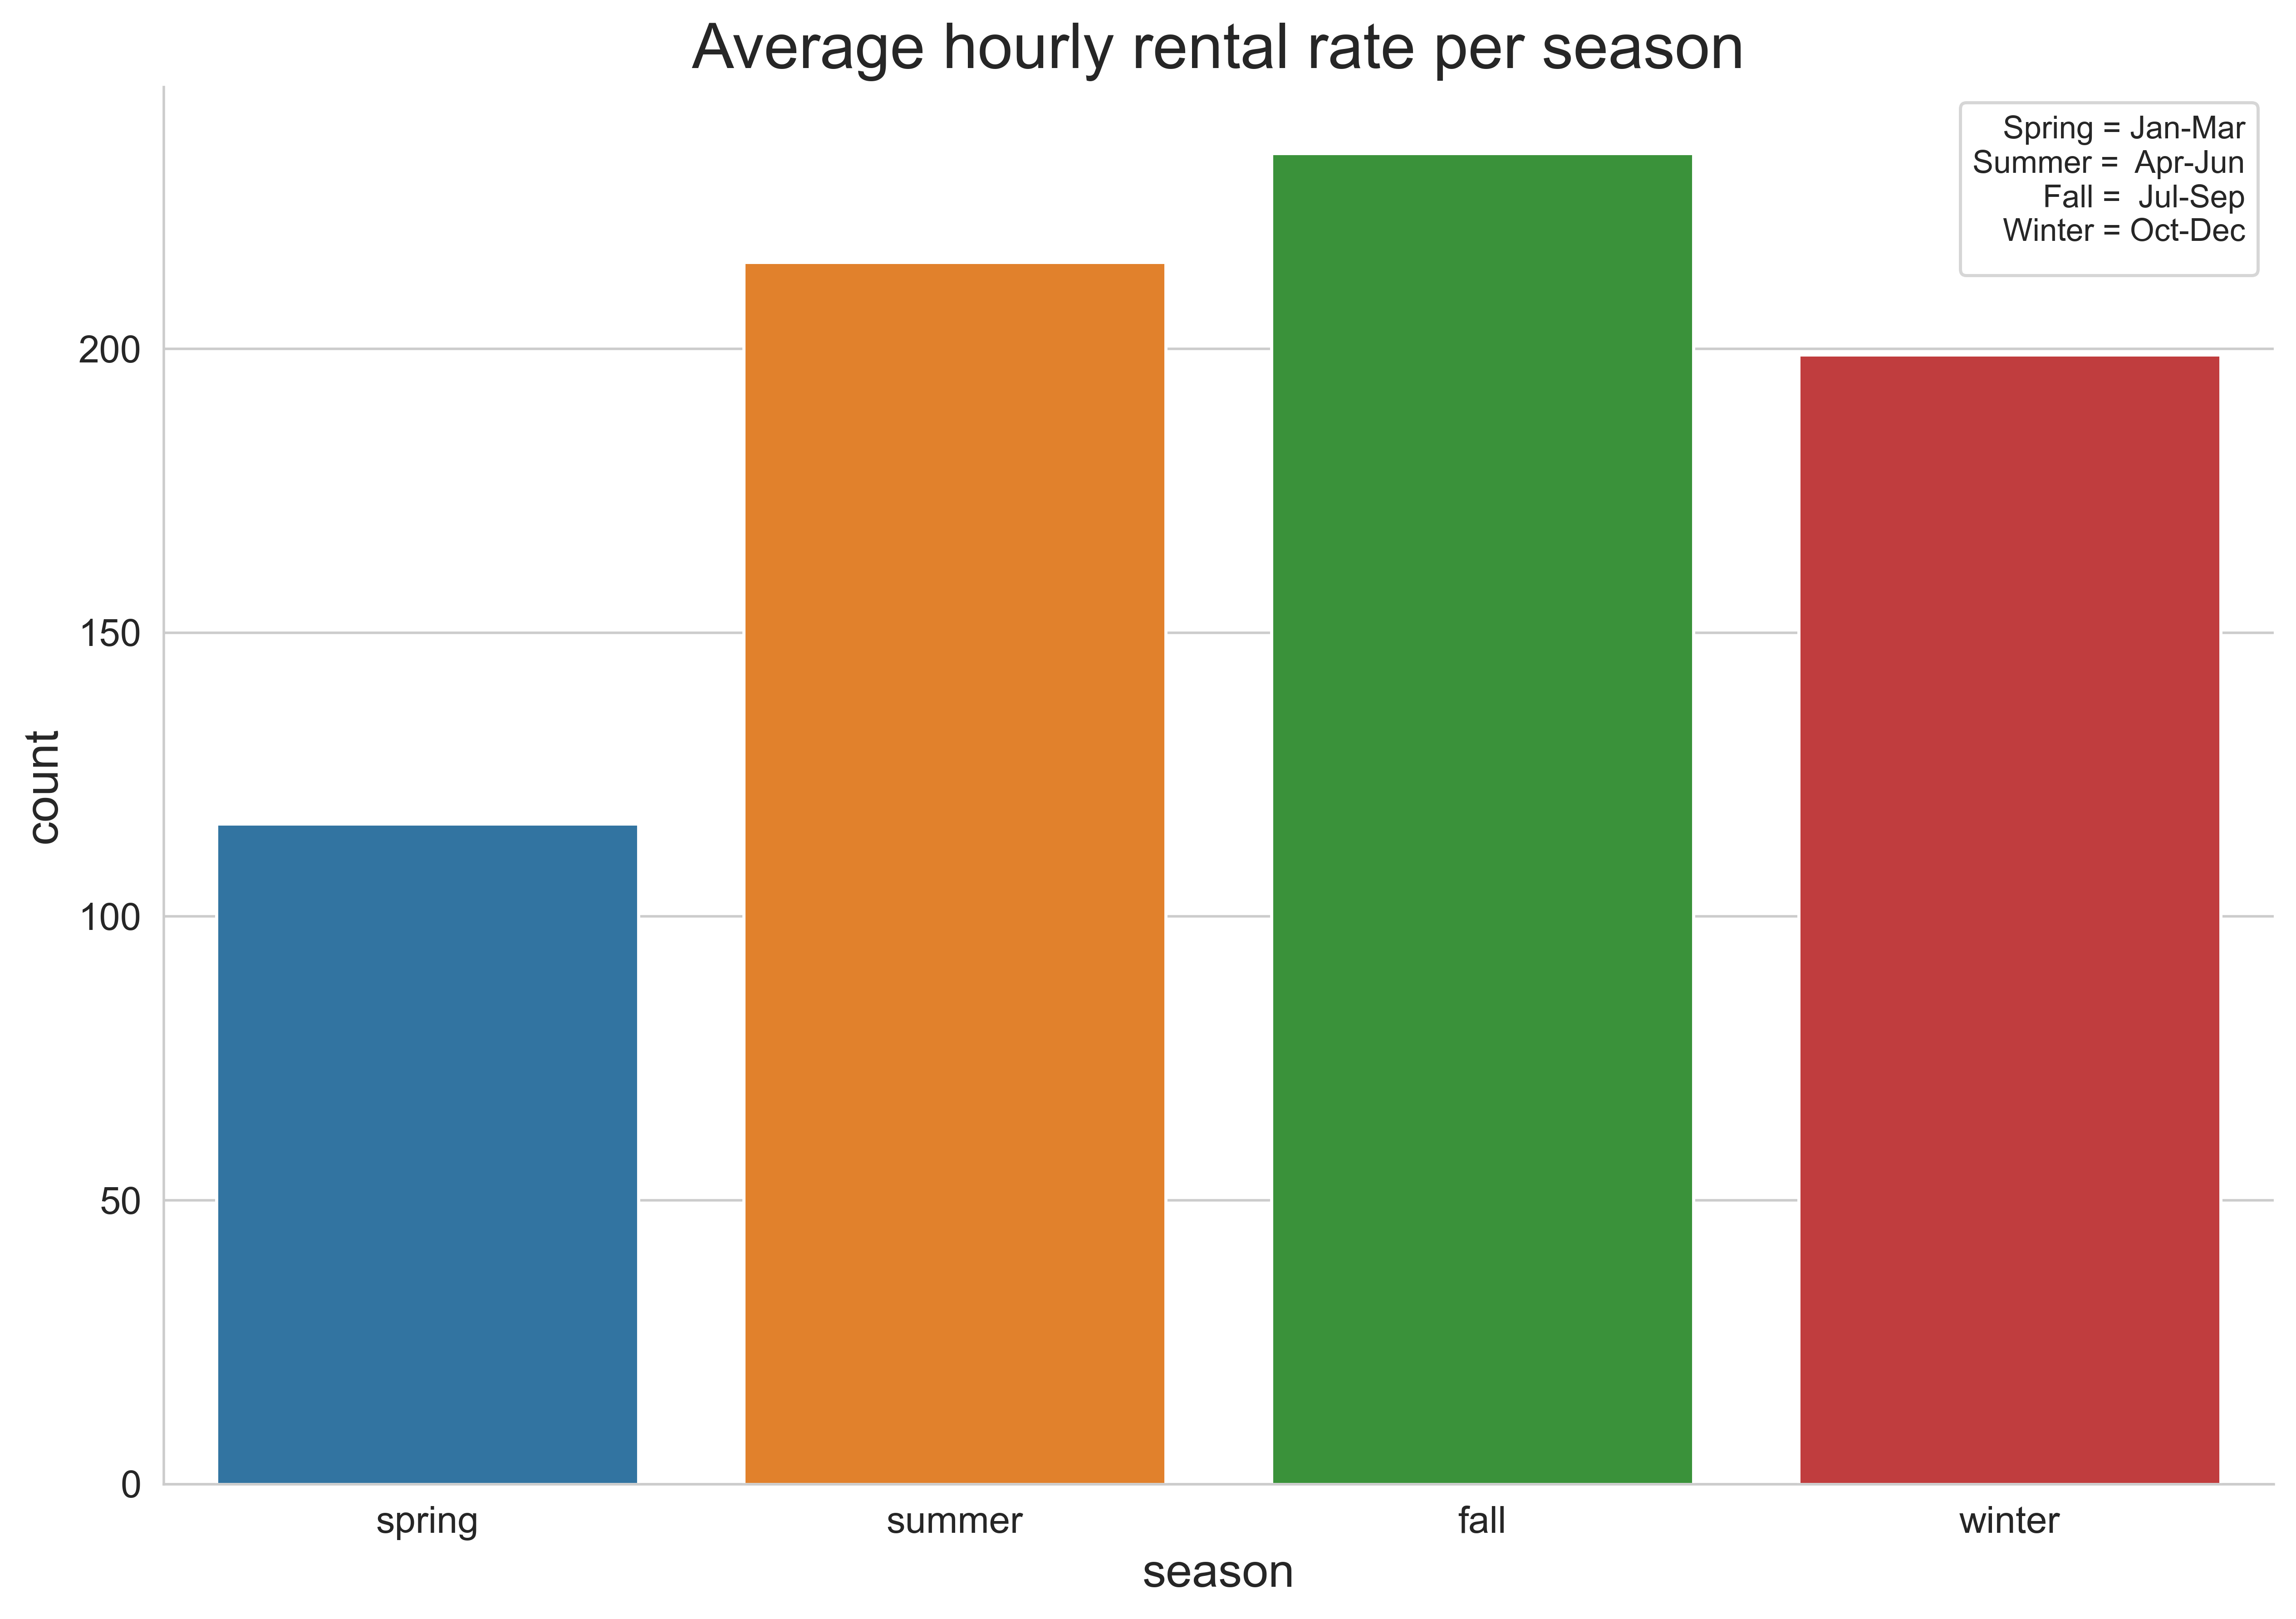

In [618]:
plt.figure(figsize=(12, 8), dpi=500)
plt.title('Average hourly rental rate per season', fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Number of passengers", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,23)
sns.barplot(data=df, x='season', y='count',estimator='mean', errorbar=None)

legend_title = 'Spring = Jan-Mar\nSummer =  Apr-Jun\nFall =  Jul-Sep\nWinter = Oct-Dec'
legend = plt.legend(title=legend_title, bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), multialignment='right')

sns.despine()
plt.savefig(fname='HourlySeasonalRentalRate', transparent=True)
plt.show()

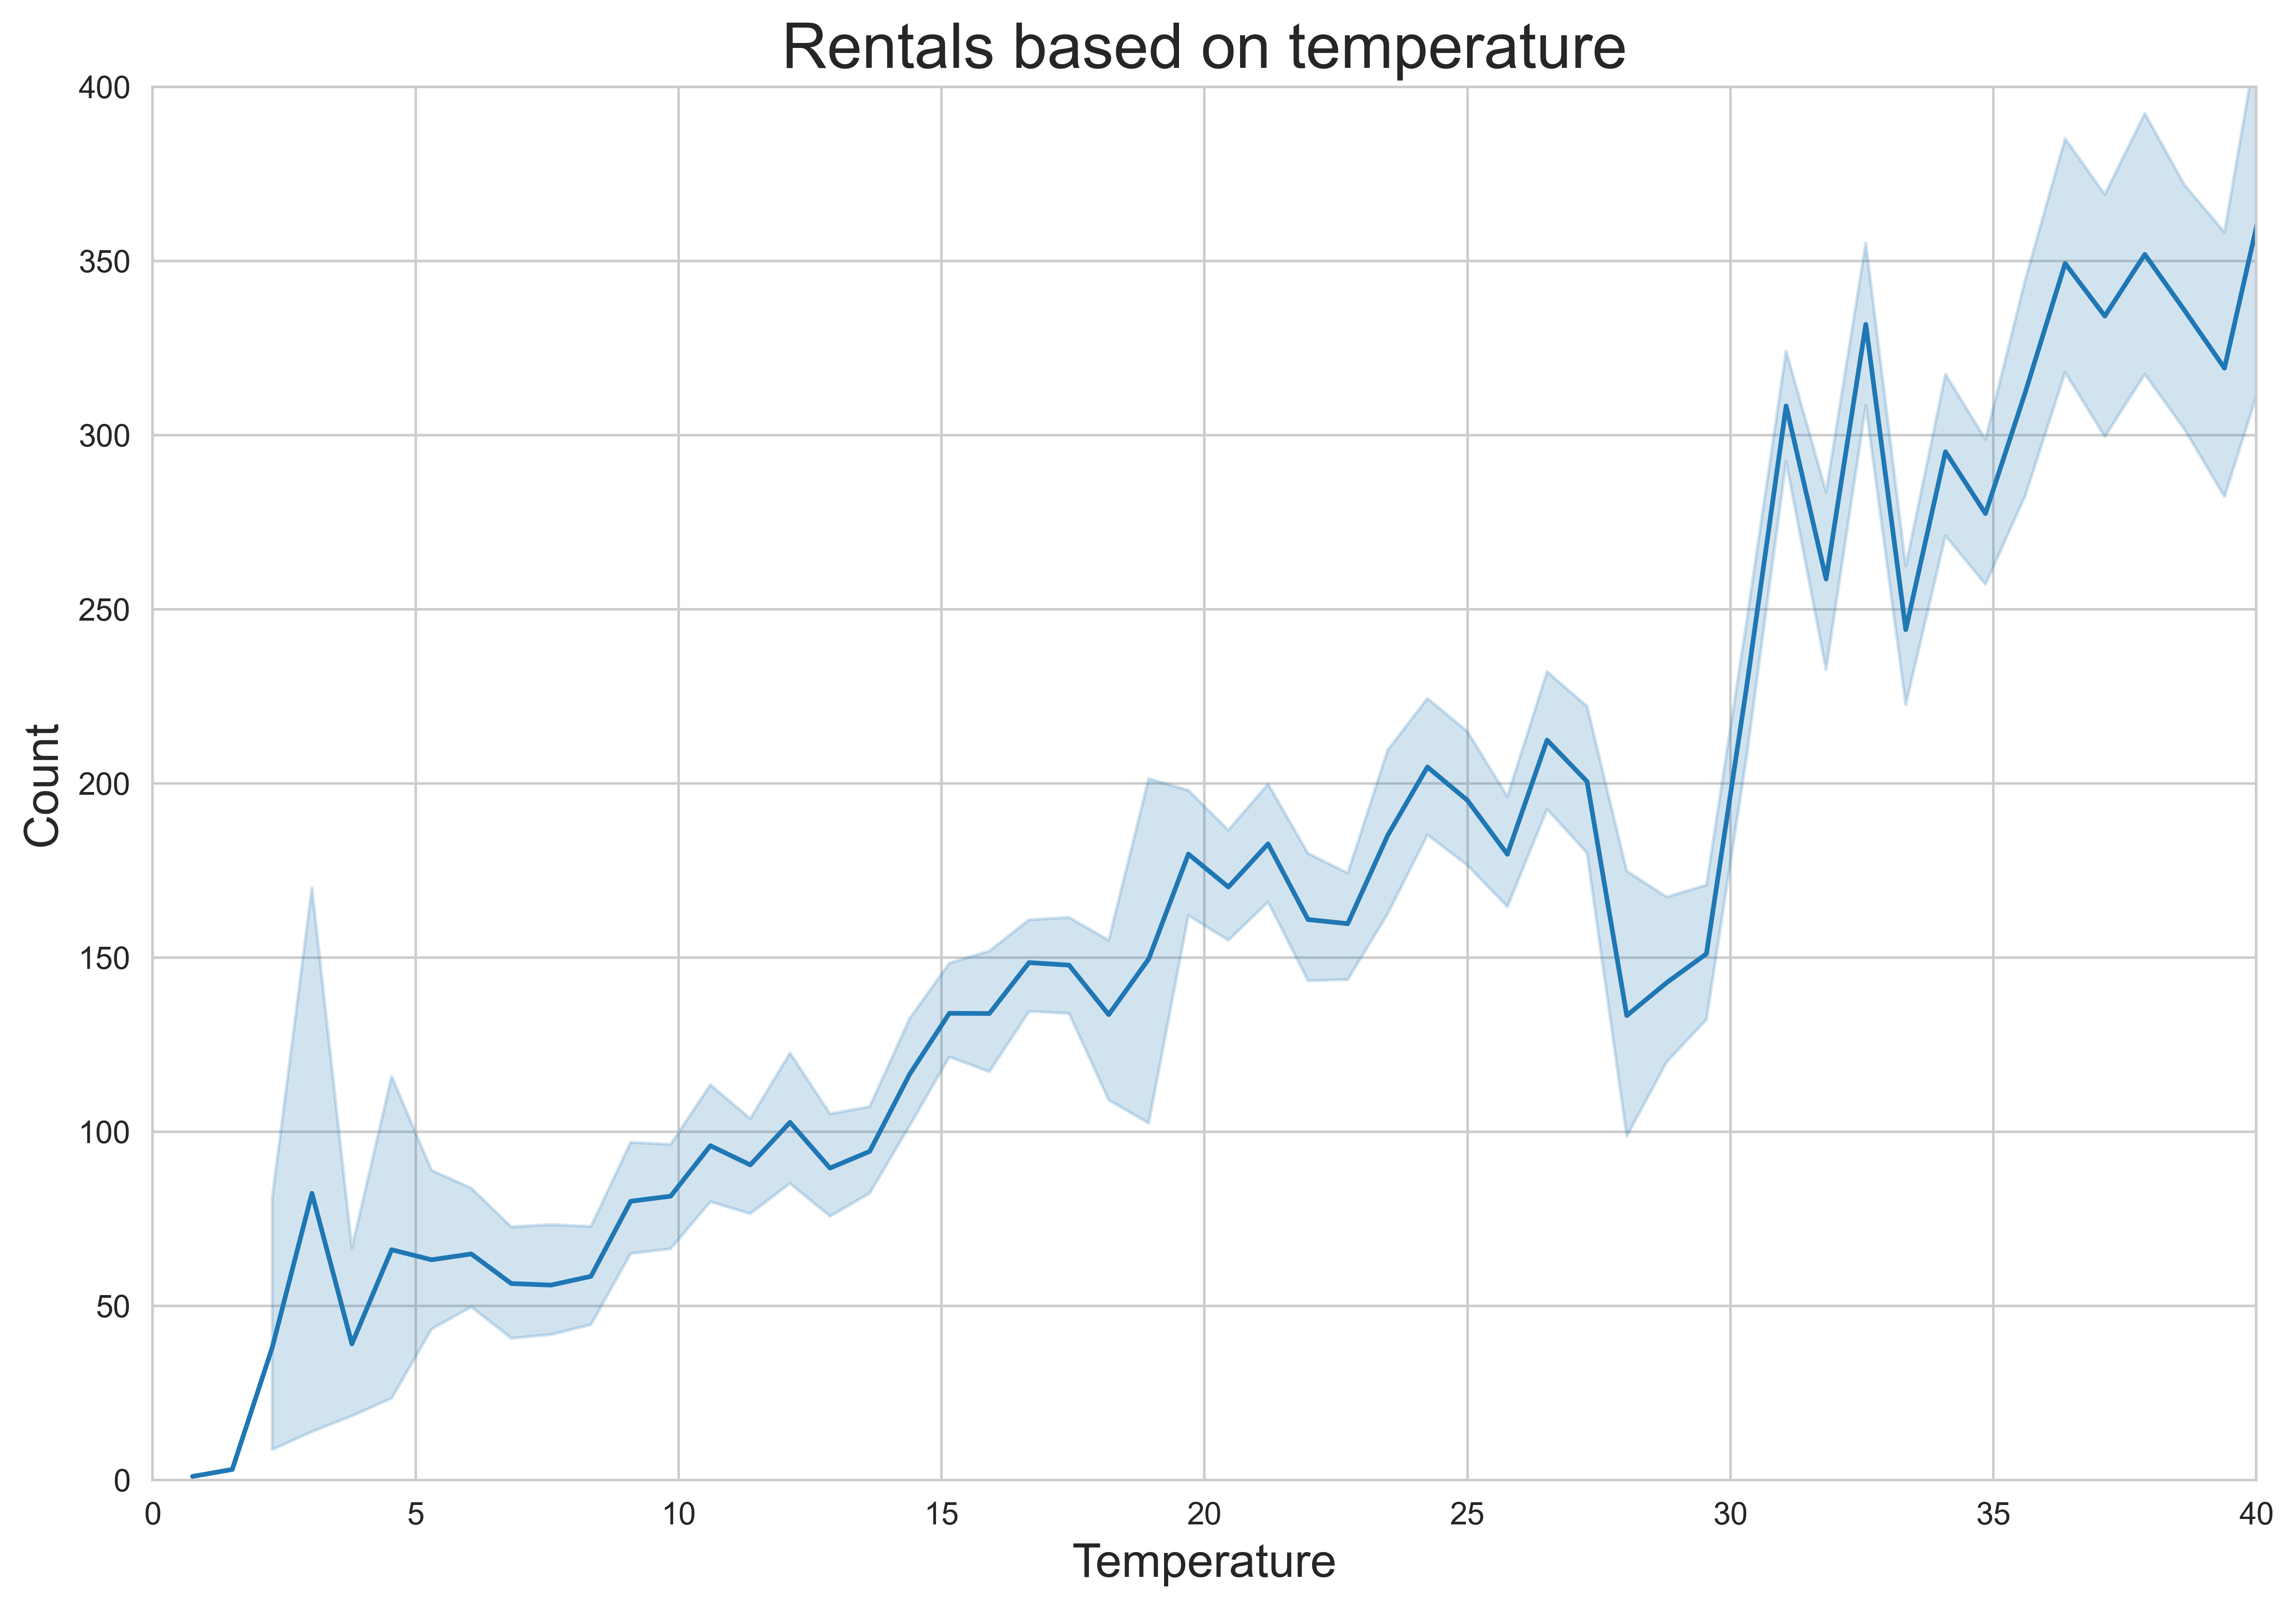

In [613]:

# Assuming you have the actual target values in y_actual and predicted values in y_pred
plt.figure(figsize=(12, 8), dpi=500)

sns.lineplot(data=df, x='atemp', y='count')

plt.title('Rentals based on temperature', fontsize=20)
plt.xlabel('Temperature', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.xlim(0,40)
plt.ylim(0,400)


plt.savefig(fname='Atemp_count_lineplot', transparent=True)
plt.show()


<Axes: xlabel='temp', ylabel='Density'>

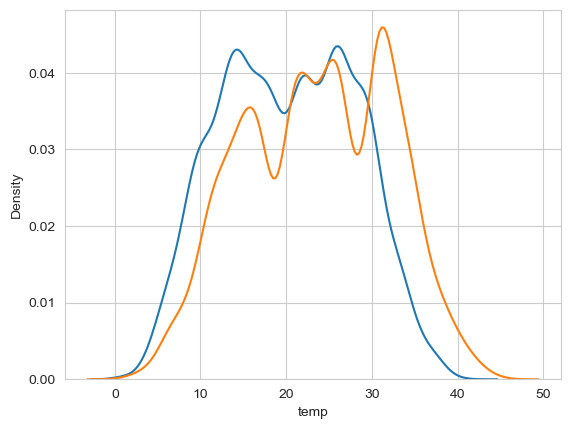

In [359]:
sns.kdeplot(data=df, x='temp')
sns.kdeplot(data=df, x="atemp")

<Axes: xlabel='temp', ylabel='windspeed'>

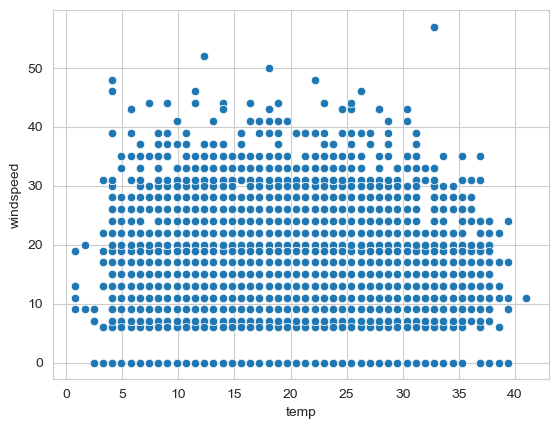

In [474]:
sns.scatterplot(data=df, x='temp', y='windspeed')

In [475]:
df.dow.value_counts()

dow
saturday     1584
sunday       1579
thursday     1553
monday       1551
wednesday    1551
tuesday      1539
friday       1529
Name: count, dtype: int64

In [476]:
df.holiday.value_counts()

holiday
no     10575
yes      311
Name: count, dtype: int64

In [477]:
df.season.value_counts()

season
winter    2734
summer    2733
fall      2733
spring    2686
Name: count, dtype: int64

In [478]:
df.weather.value_counts()

weather
Clear     7192
Cloudy    2834
Wet        859
Storms       1
Name: count, dtype: int64

<Axes: >

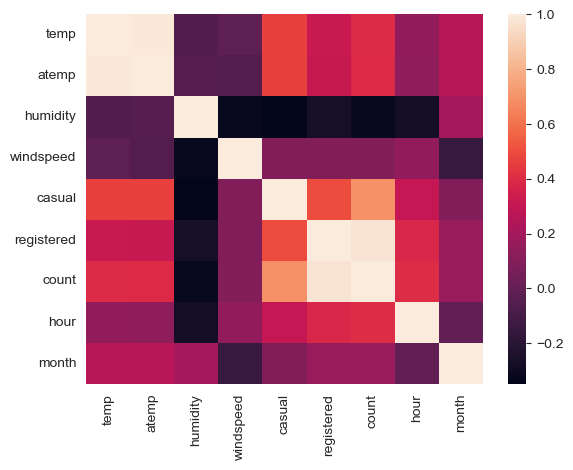

In [479]:
sns.heatmap(df.corr(numeric_only=True))

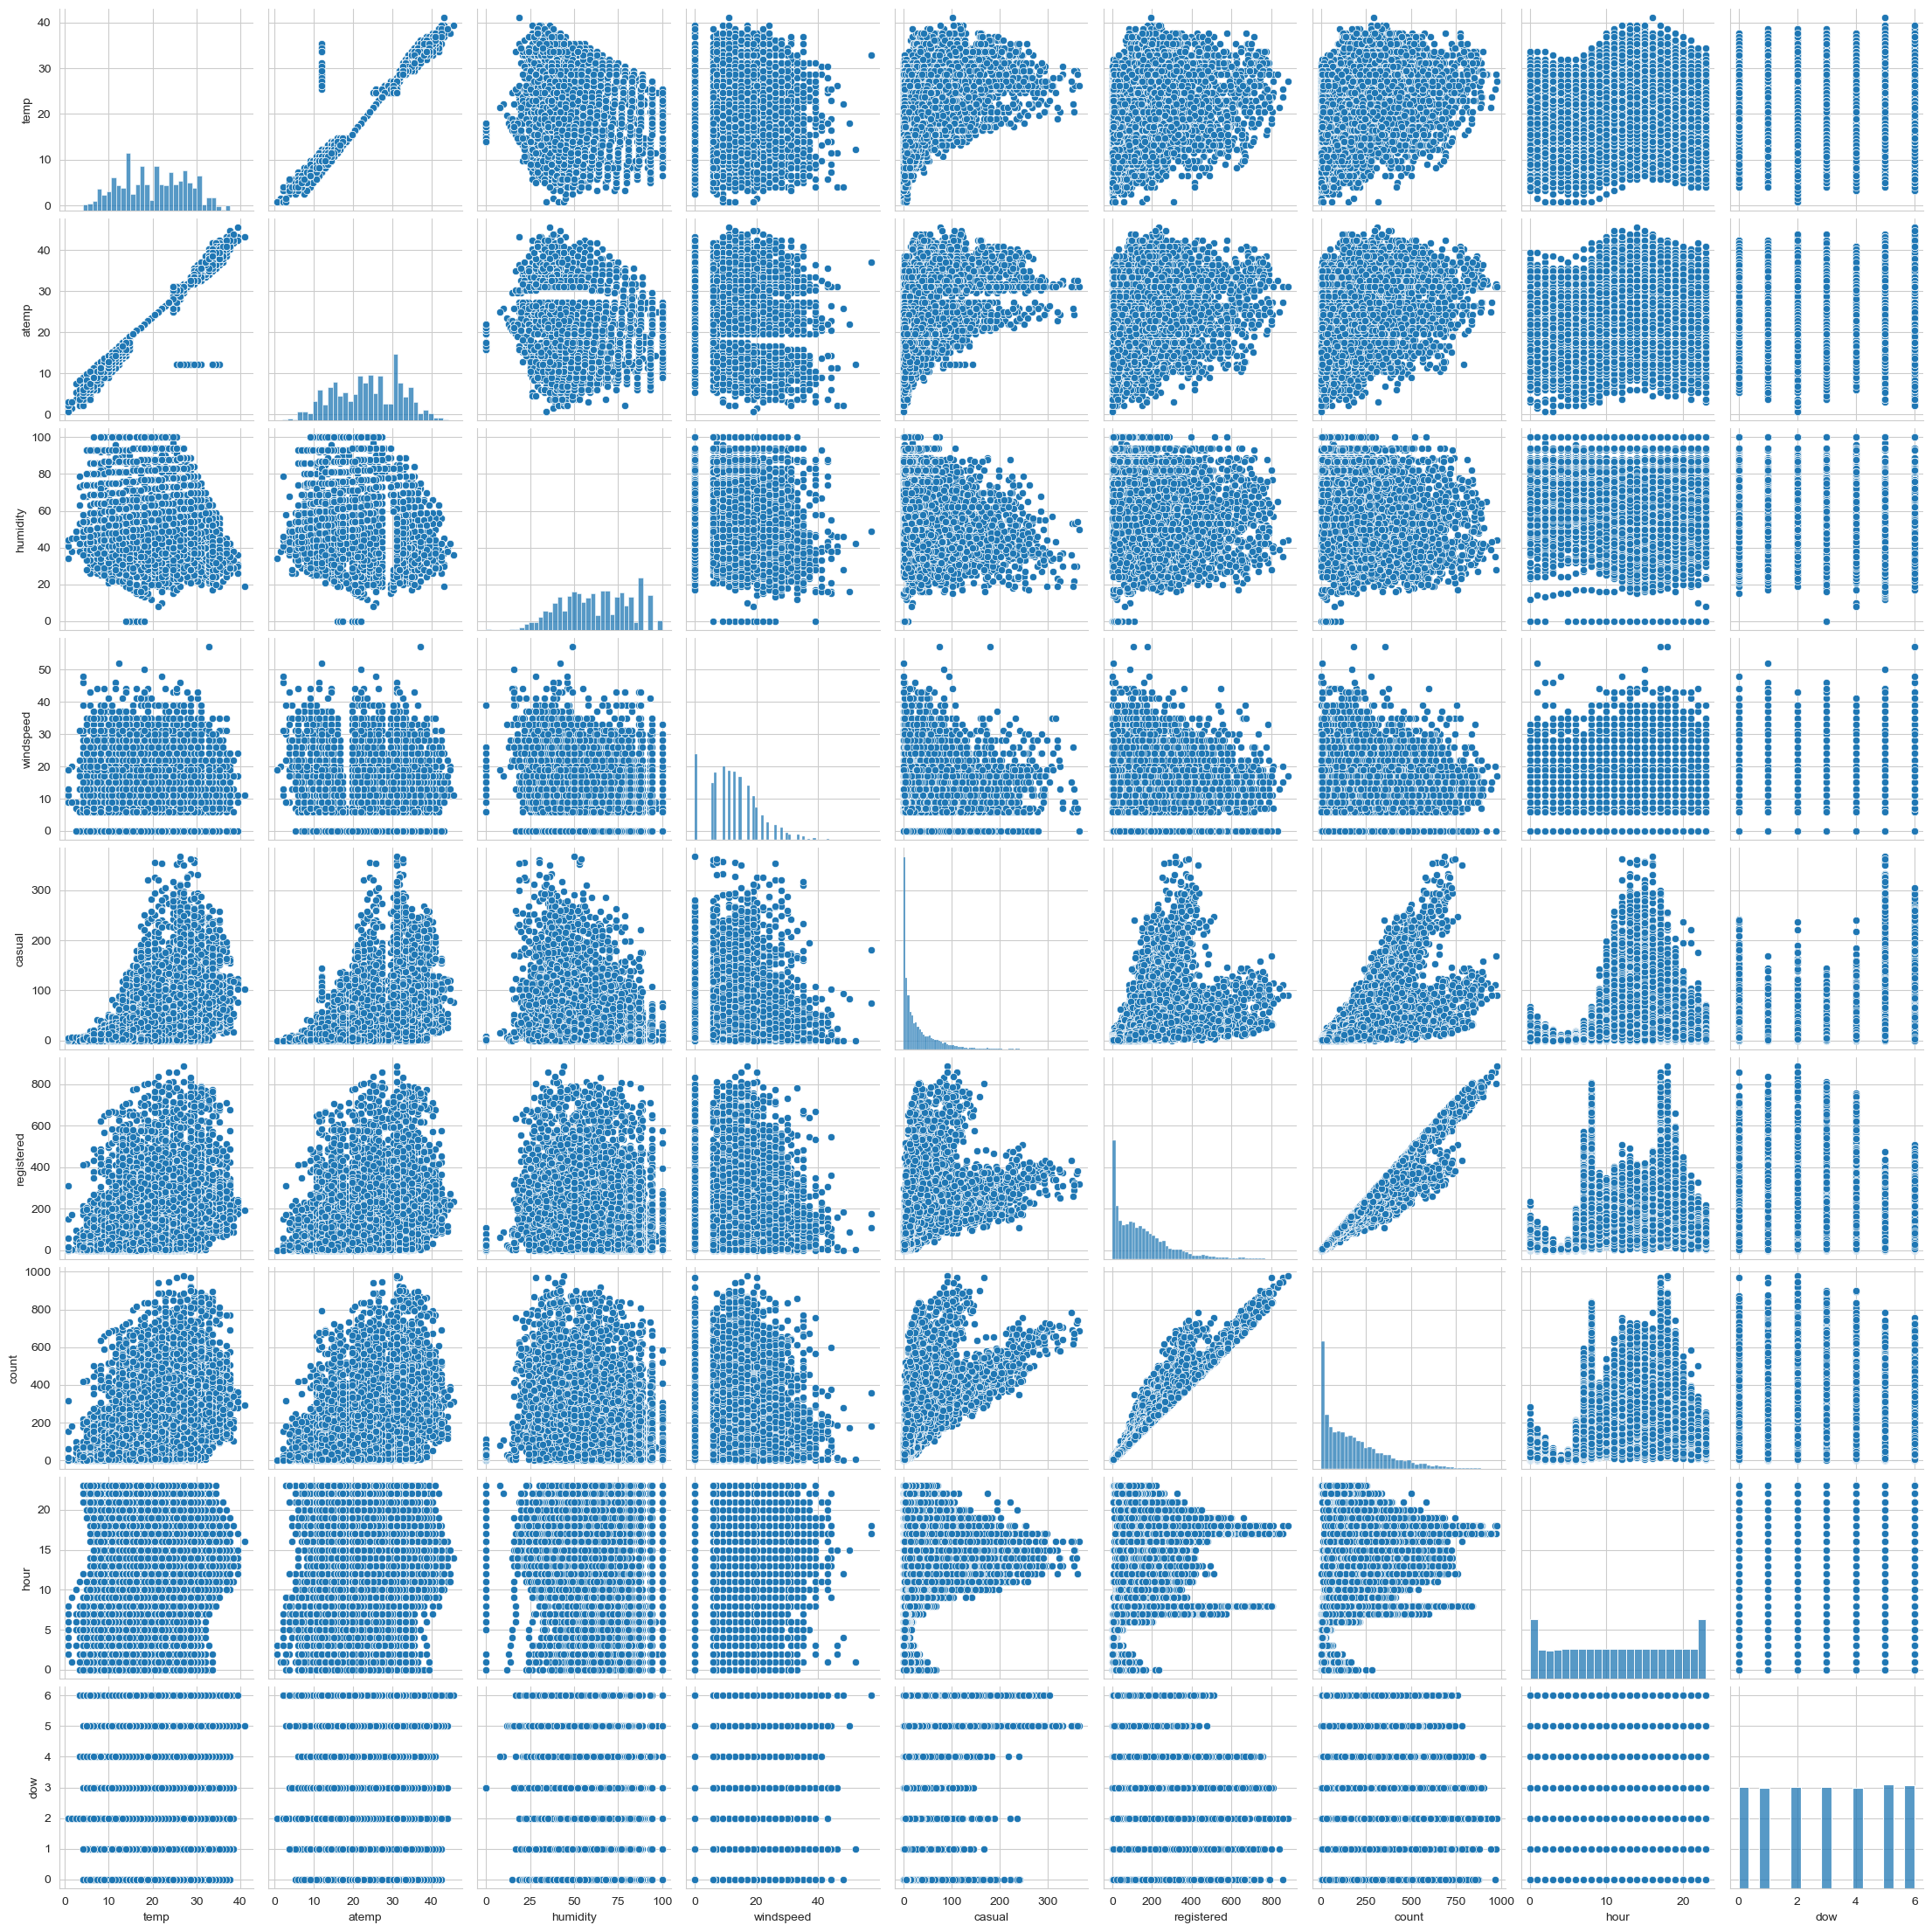

In [201]:
g = sns.pairplot(df)

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  object 
 1   holiday     17379 non-null  object 
 2   workingday  17379 non-null  object 
 3   weather     17379 non-null  object 
 4   temp        17379 non-null  float64
 5   atemp       17379 non-null  float64
 6   humidity    17379 non-null  int64  
 7   windspeed   17379 non-null  float64
 8   casual      10886 non-null  float64
 9   registered  10886 non-null  float64
 10  count       10886 non-null  float64
 11  hour        17379 non-null  int32  
 12  dow         17379 non-null  object 
dtypes: float64(6), int32(1), int64(1), object(5)
memory usage: 1.8+ MB


In [106]:
df.describe()

season       holiday    workingday       weather         temp   
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000  \
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered   
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000  \
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count          hour           dow  
count  10886.000000  10886.000000  10886.000000  
mean     191.574132     11.541613      3.013963  
std      181.144454      6.915838      2.004585  
min        1.000000      0.000000      0.000000  
25%       42.000000      6.000000      1.000000  
50%      145.000000     12.000000      3.000000  
75%      284.000000     18.000000      5.000000  
max      977.000000     23.000000      6.000000

Since there is already a feature called 'atemp', or apparent temperature, which takes into account the percieved temperature, the 'temp' feature is dropped.

The datetime-feature will be used to simply extract the exact hour of the day which a bike was rented on. This way, all values within a single hour (eg. between 14:00 and 14:59) will be converted into that hour (14).

It is more interesting to find out exactly how many bikes were rented during a specific hour, regardless of if the renter was a member or not. Therefore, the features 'casual' and 'registered' will be combined.

## Looking at training data - doing cross fold validation

In [480]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour', 'dow',
       'month'],
      dtype='object')

In [481]:
target_variable = 'count'

X = df.drop(columns=[target_variable, 'casual', 'registered','temp'])
y = df[target_variable]

In [482]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [483]:
X_train

season holiday workingday weather   atemp  humidity  windspeed  hour   
9792  winter      no        yes   Clear  24.240        39    19.9995     9  \
3815    fall      no        yes   Clear  27.275        94     6.0032    23   
2420  summer      no        yes   Clear  40.910        37    15.0013    18   
4176  winter      no        yes   Clear  23.485        63    12.9980     1   
4283  winter     yes         no  Cloudy  32.575        48     6.0032    12   
...      ...     ...        ...     ...     ...       ...        ...   ...   
9372    fall      no        yes   Clear  30.305        65     7.0015    21   
7291  summer      no        yes  Cloudy  22.725        88    16.9979     4   
1344  summer      no        yes   Clear  16.665        53     8.9981    21   
7293  summer      no        yes  Cloudy  22.725        88    11.0014     6   
1289  spring      no        yes   Clear  31.060        39    16.9979    14   

            dow  month  
9792     friday     10  
3815     friday      9  
2420  wednesday      6  
4176   thursday     10  
4283     monday     10  
...         ...    ...  
9372   thursday      9  
7291   thursday      5  
1344     friday      4  
7293   thursday      5  
1289     friday      3  

[8164 rows x 10 columns]

In [484]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity',
       'windspeed', 'hour', 'dow', 'month'],
      dtype='object')

In [491]:


# Preprocess numerical columns
num_columns = ['atemp', 'humidity', 'windspeed', 'hour', 'month']
num_trans = make_pipeline(
                        SimpleImputer(strategy='median'), 
                        StandardScaler())


# Preprocess categorical columns
cat_columns = ['season', 'holiday', 'workingday', 'weather', 'dow']
cat_trans = OneHotEncoder(handle_unknown='ignore', drop='if_binary')

# Transforming columns
preprocessor = make_column_transformer(
                                    (num_trans, num_columns),
                                    (cat_trans, cat_columns))

## Baseline

In [617]:
# Create the baseline model
baseline_model = DummyRegressor(strategy="mean")

# Fit the model to the training data
baseline_model.fit(X_train, y_train)

# Predict on the test data
y_pred_baseline = baseline_model.predict(X_test)

# Calculate the mean absolute error
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)

# Calculate the mean absolute percentage error

mape_baseline = mean_absolute_percentage_error(y_test, y_pred_baseline)

# Evaluate the baseline model
baseline_score = baseline_model.score(X_test, y_test)


print("  Mean Absolute Error:", round(mae_baseline, 3))
print('')
print("  Mean Absolute Percentage Error:", round(mape_baseline, 3))
print('')
print("  R-squared:", round(baseline_score, 4))

  Mean Absolute Error: 145.792

  Mean Absolute Percentage Error: 8.031

  R-squared: -0.0


## Model selection

In [493]:
classifiers = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), RandomForestRegressor(), SVR()]

for clf in classifiers:
    pipe = make_pipeline(preprocessor, clf)
    grid = GridSearchCV(estimator=pipe,
                        cv = 10,
                        scoring = 'r2',
                        param_grid={})
    
    grid.fit(X_train, y_train)
    score = grid.best_score_
    print(f'{clf} has r2 of {round(score, 4)} \n')

/Users/axelreman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


LinearRegression() has r2 of 0.3471 



/Users/axelreman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Lasso() has r2 of 0.3469 



/Users/axelreman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Ridge() has r2 of 0.3472 



/Users/axelreman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ElasticNet() has r2 of 0.3158 



/Users/axelreman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RandomForestRegressor() has r2 of 0.8587 



/Users/axelreman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVR() has r2 of 0.3398 



LinearRegression() has accuracy of 0.346 

Lasso() has accuracy of 0.345 

Ridge() has accuracy of 0.346 

ElasticNet() has accuracy of 0.308 

RandomForestRegressor() has accuracy of 0.853 

SVR() has accuracy of 0.346 

## Hyperparam tuning

In [518]:
param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],  # Number of trees in the random forest
    'randomforestregressor__random_state': [42]  # Random seed for reproducibility
}

clf = RandomForestRegressor()
pipe = make_pipeline(preprocessor, clf)

grid = GridSearchCV(pipe, param_grid=param_grid, scoring='r2', cv=10)

grid.fit(X_train, y_train)

print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)

/Users/axelreman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/axelreman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/axelreman/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Best score: 0.8605887161742013
Best params: {'randomforestregressor__n_estimators': 300, 'randomforestregressor__random_state': 42}


`Best score:` 0.8605887161742013

`Best params:` {'randomforestregressor__n_estimators': 300, 'randomforestregressor__random_state': 42}

In [554]:
y_pred

array([356.35      , 161.94666667, 499.88666667, ..., 120.44666667,
       127.88666667, 180.55666667])

In [557]:
y_pred = grid.predict(X_train)

print(f'MAE score: {mean_absolute_error(y_train, y_pred)}')
print('')
print(f'MAPE score: {mean_absolute_percentage_error(y_train, y_pred)}')
print('')
print(f'r2 score: {r2_score(y_train, y_pred)}')

MAE score: 16.114784775203564

MAPE score: 0.15647319408287236

r2 score: 0.9814976439471023


In [616]:
y_pred = grid.predict(X_test)

print("MAE on test data:", round(mean_absolute_error(y_test, y_pred), 3))
print('')
print(f'MAPE on test data: {round(mean_absolute_percentage_error(y_test, y_pred), 3)}')
print('')
print("R2 on test data:", round(r2_score(y_test, y_pred), 3))

MAE on test data: 44.61

MAPE on test data: 0.406

R2 on test data: 0.866


<Axes: >

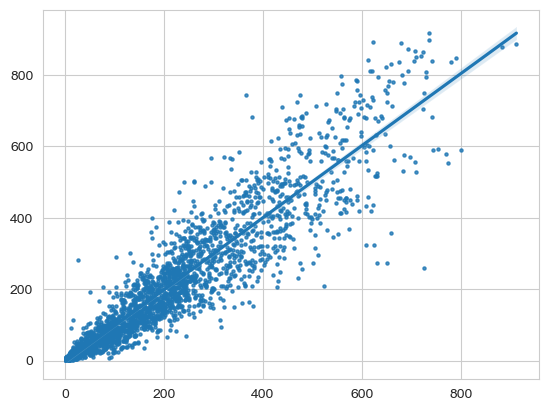

In [521]:
sns.regplot(x=y_pred.reshape(-1), y=np.array(y_test).reshape(-1), scatter_kws={'s': 5})

In [522]:
df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [523]:
y_test.shape

(2722,)

In [524]:
X_test

season holiday workingday weather   atemp  humidity  windspeed  hour   
8686     fall      no         no   Clear  34.850        77    11.0014     7  \
8453     fall      no        yes  Cloudy  35.605        38     0.0000    14   
10419  winter      no        yes   Clear  21.970        54    16.9979    13   
3192     fall      no        yes  Cloudy  37.120        59    11.0014    22   
176    spring      no         no   Clear   8.335        32    30.0026    15   
...       ...     ...        ...     ...     ...       ...        ...   ...   
5795   spring     yes         no   Clear  10.605        44    30.0026    15   
7697   summer      no        yes   Clear  31.060        57    15.0013     2   
1569   summer      no        yes  Cloudy  24.240        88    15.0013     7   
7799   summer      no        yes  Cloudy  23.485        77    15.0013     8   
5329   winter      no        yes   Clear  22.725        82     8.9981     3   

            dow  month  
8686   saturday      8  
8453     friday      7  
10419    monday     11  
3192    tuesday      8  
176    saturday      1  
...         ...    ...  
5795     monday      1  
7697     friday      6  
1569     monday      4  
7799    tuesday      6  
5329     friday     12  

[2722 rows x 10 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


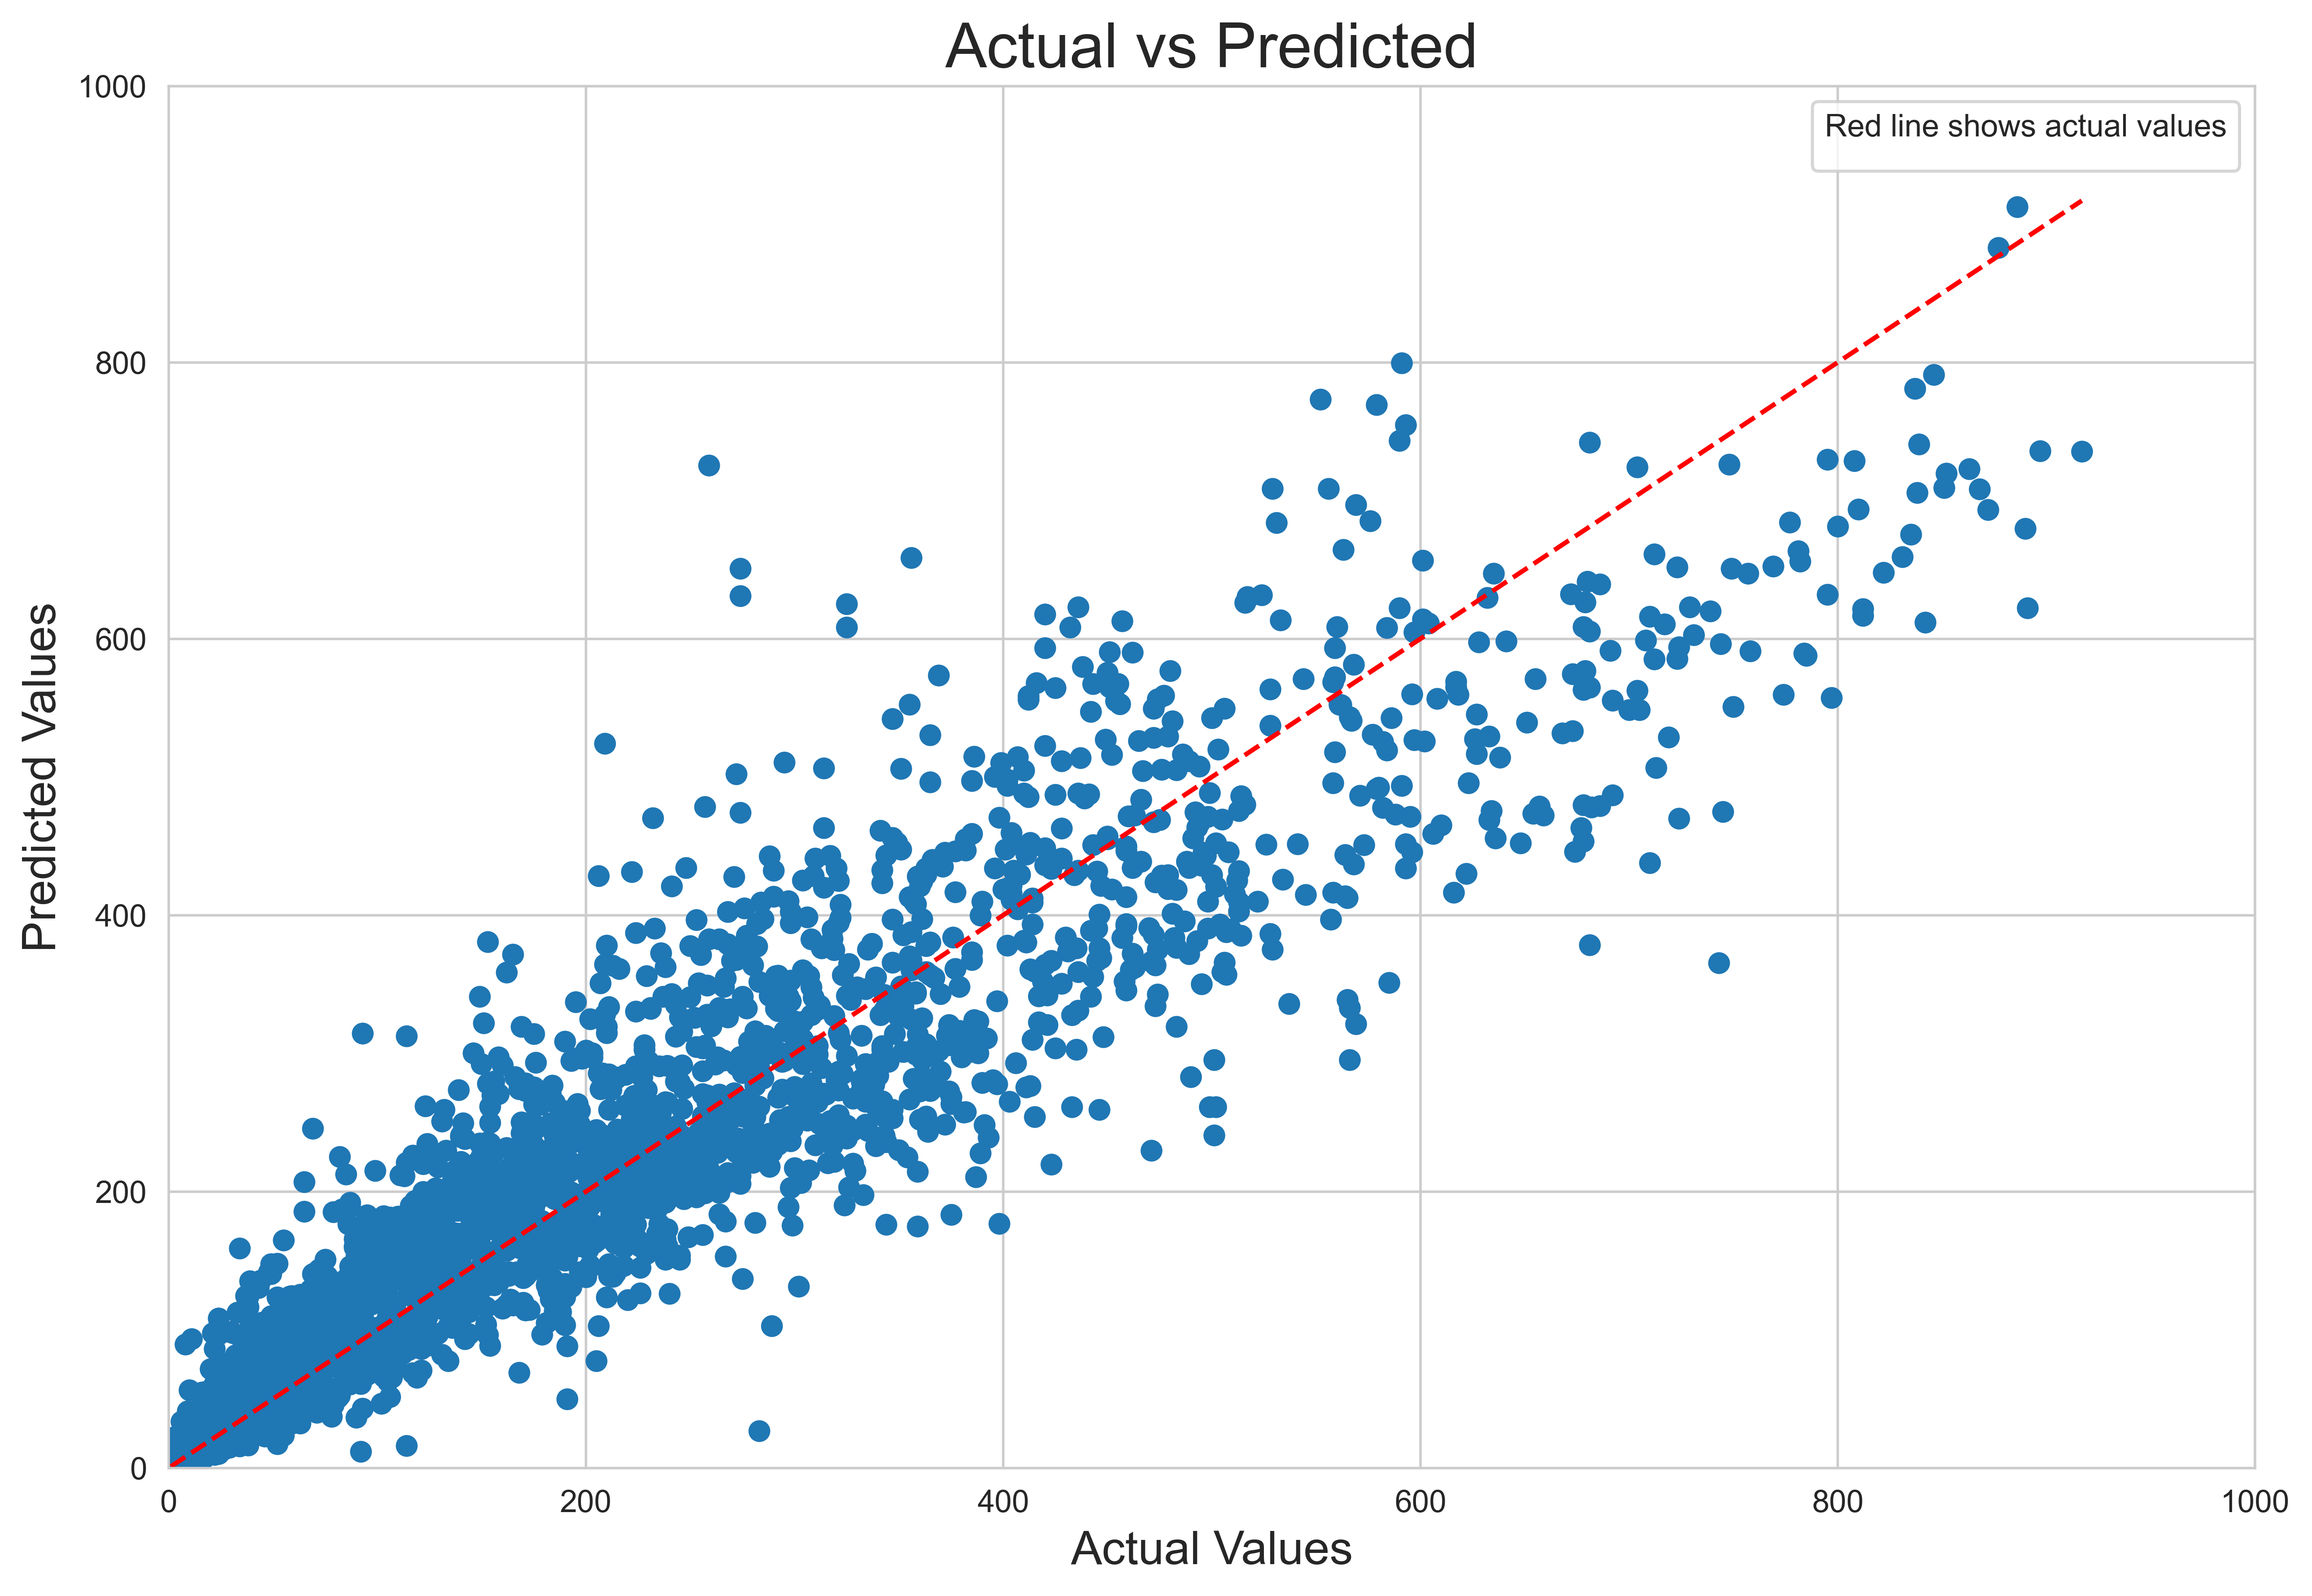

In [609]:
# Assuming you have the actual target values in y_actual and predicted values in y_pred
plt.figure(figsize=(12, 8), dpi=500)

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)

plt.xlim(0,1000)
plt.ylim(0,1000)

plt.legend(title='Red line shows actual values')

plt.savefig(fname='ActualvsPredictedScatter', transparent=True)
plt.show()


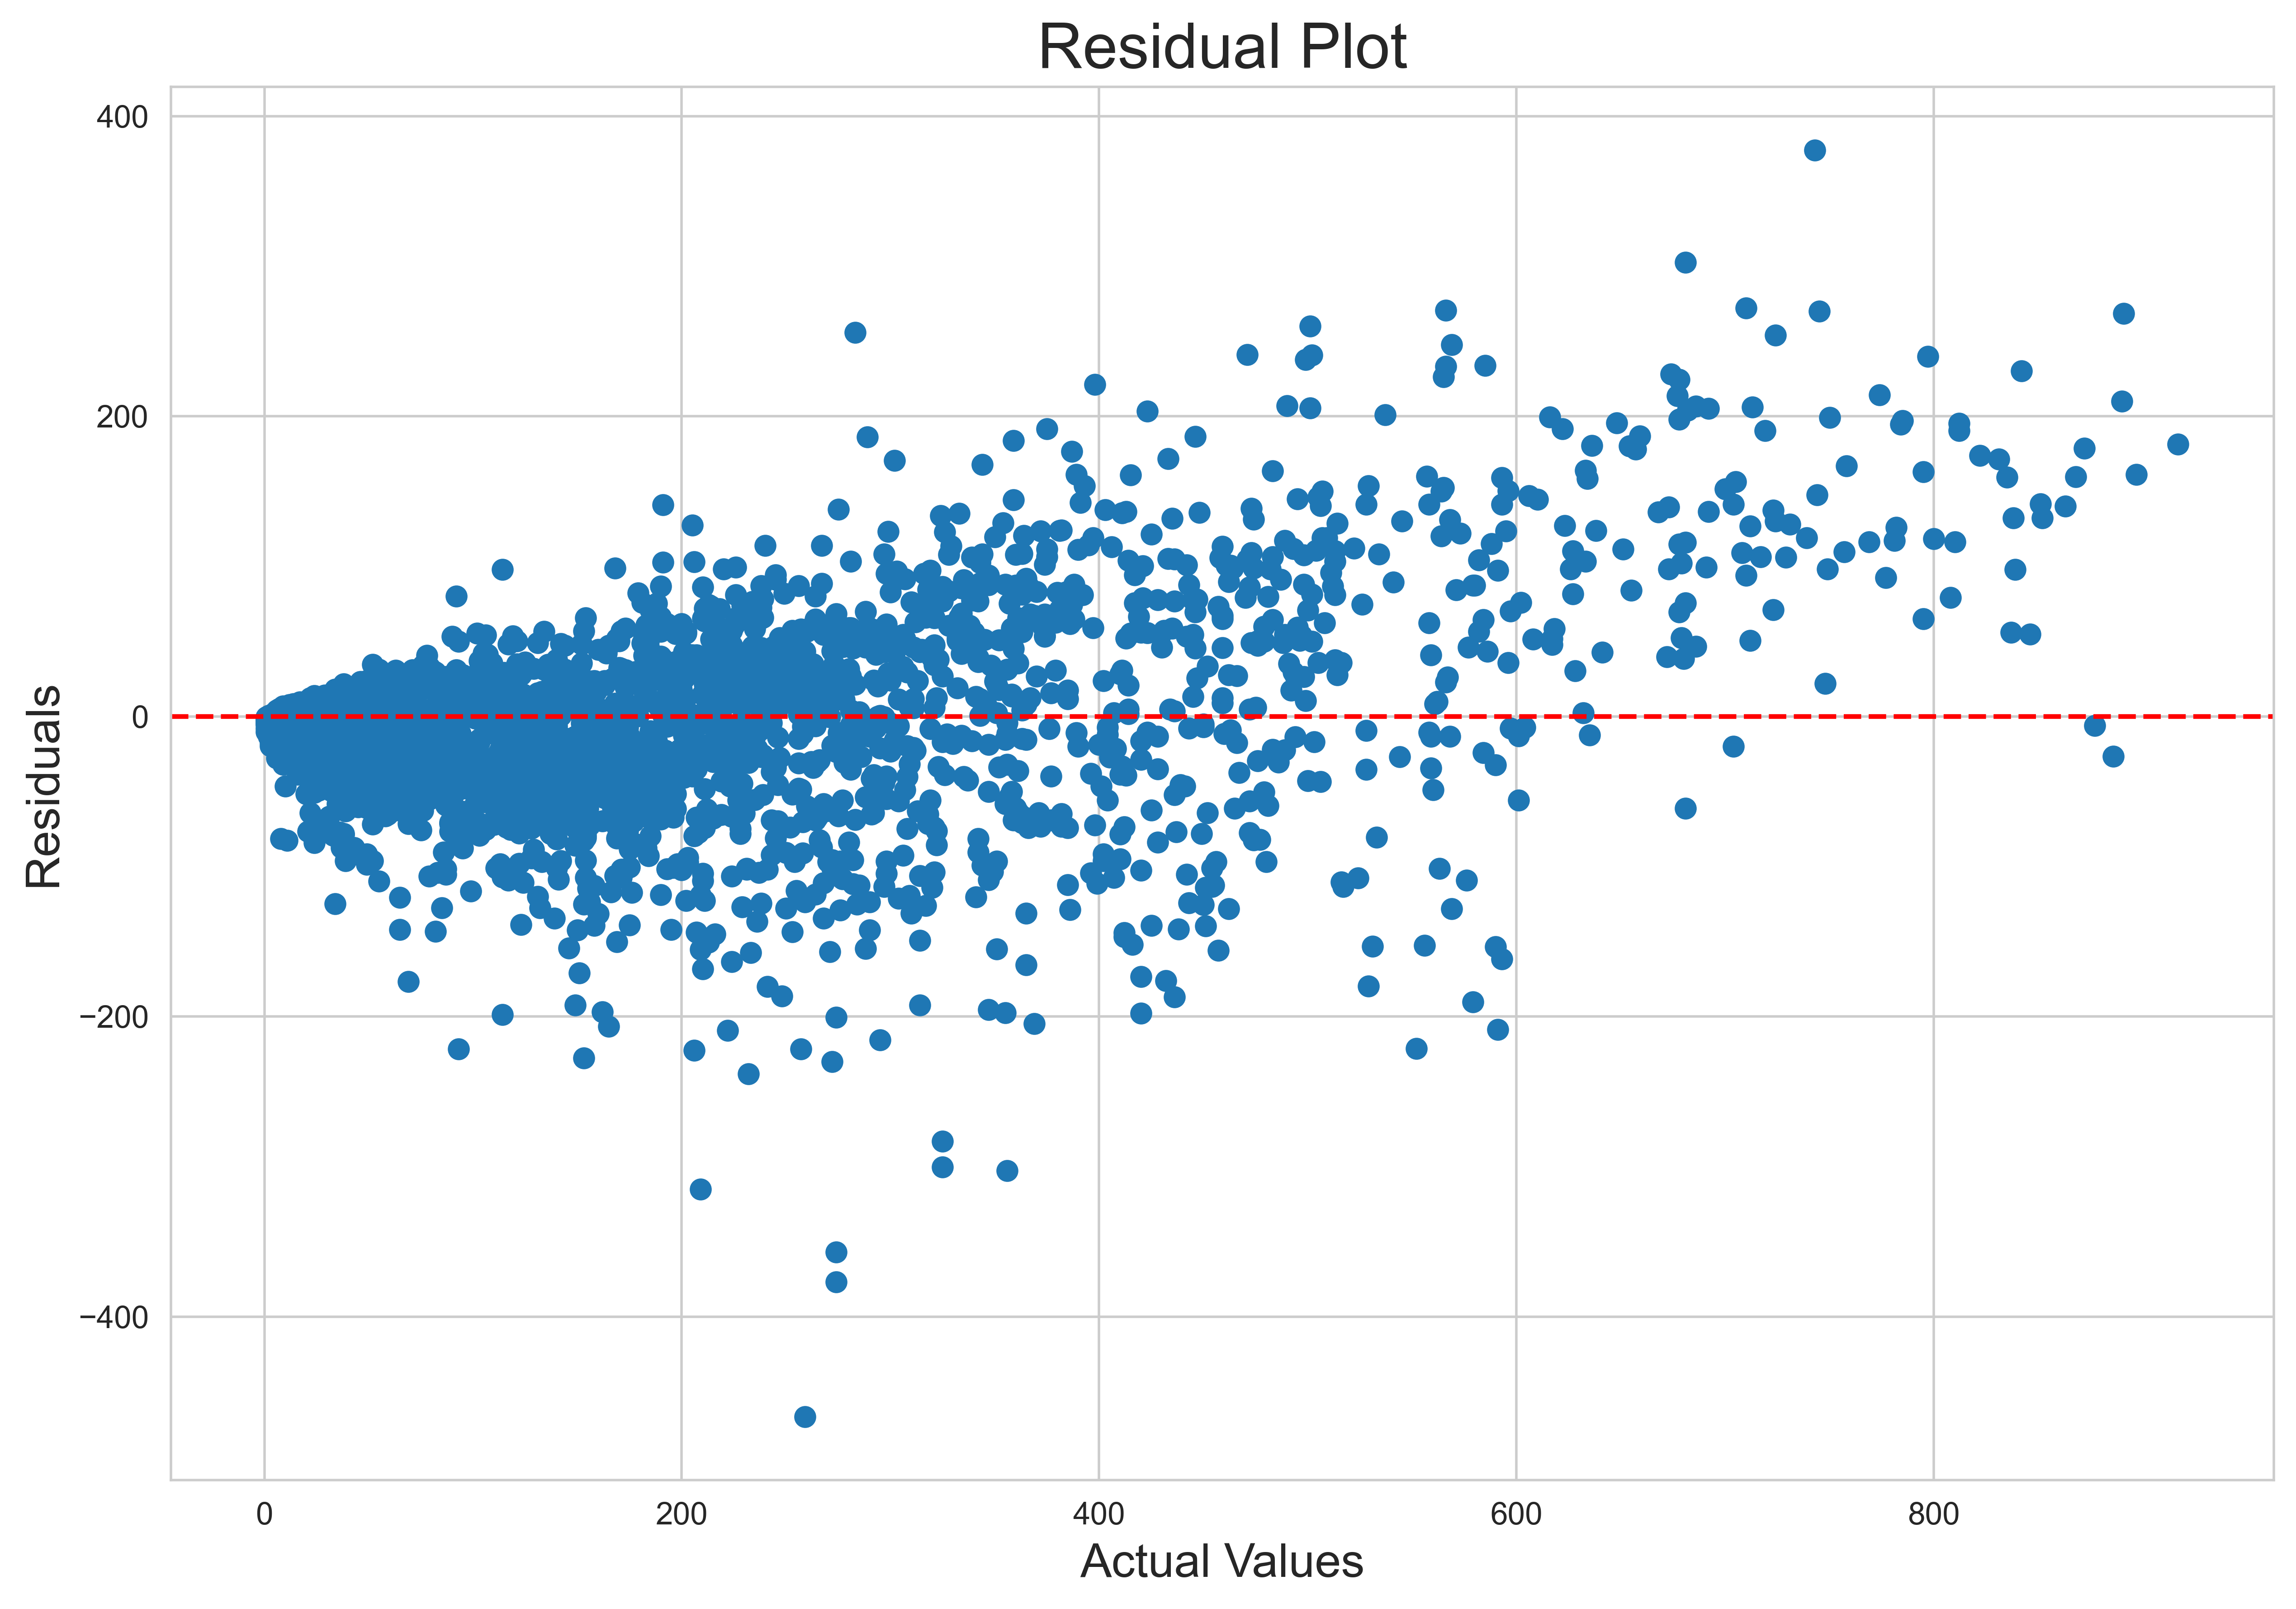

In [610]:
import matplotlib.pyplot as plt

# Assuming you have the actual target values in y_test and predicted values in y_pred
residuals = y_test - y_pred

plt.figure(figsize=(12, 8), dpi=500)
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.title('Residual Plot', fontsize=20)

plt.savefig(fname='ResidualPlot', transparent=True)
plt.show()


If the dots in a residual plot deviate higher on the y-axis as you move further along the x-axis, it suggests that the model is underpredicting the target variable. This means that the predicted values are consistently lower than the actual values.

Such a pattern indicates that the model has a systematic bias towards making predictions that are too low. This could be due to various reasons, such as missing relevant features, inadequate complexity in the model, or a poor fit to the underlying data distribution.

In this case, the data points are mainly found on the negative side of the y-intercept with low values of actual bike rentals, and positive side at high values of rentals. This indicates that the model is overpredicting the amount of bike rentals at off-peak times, and underpredicting at peak hours.

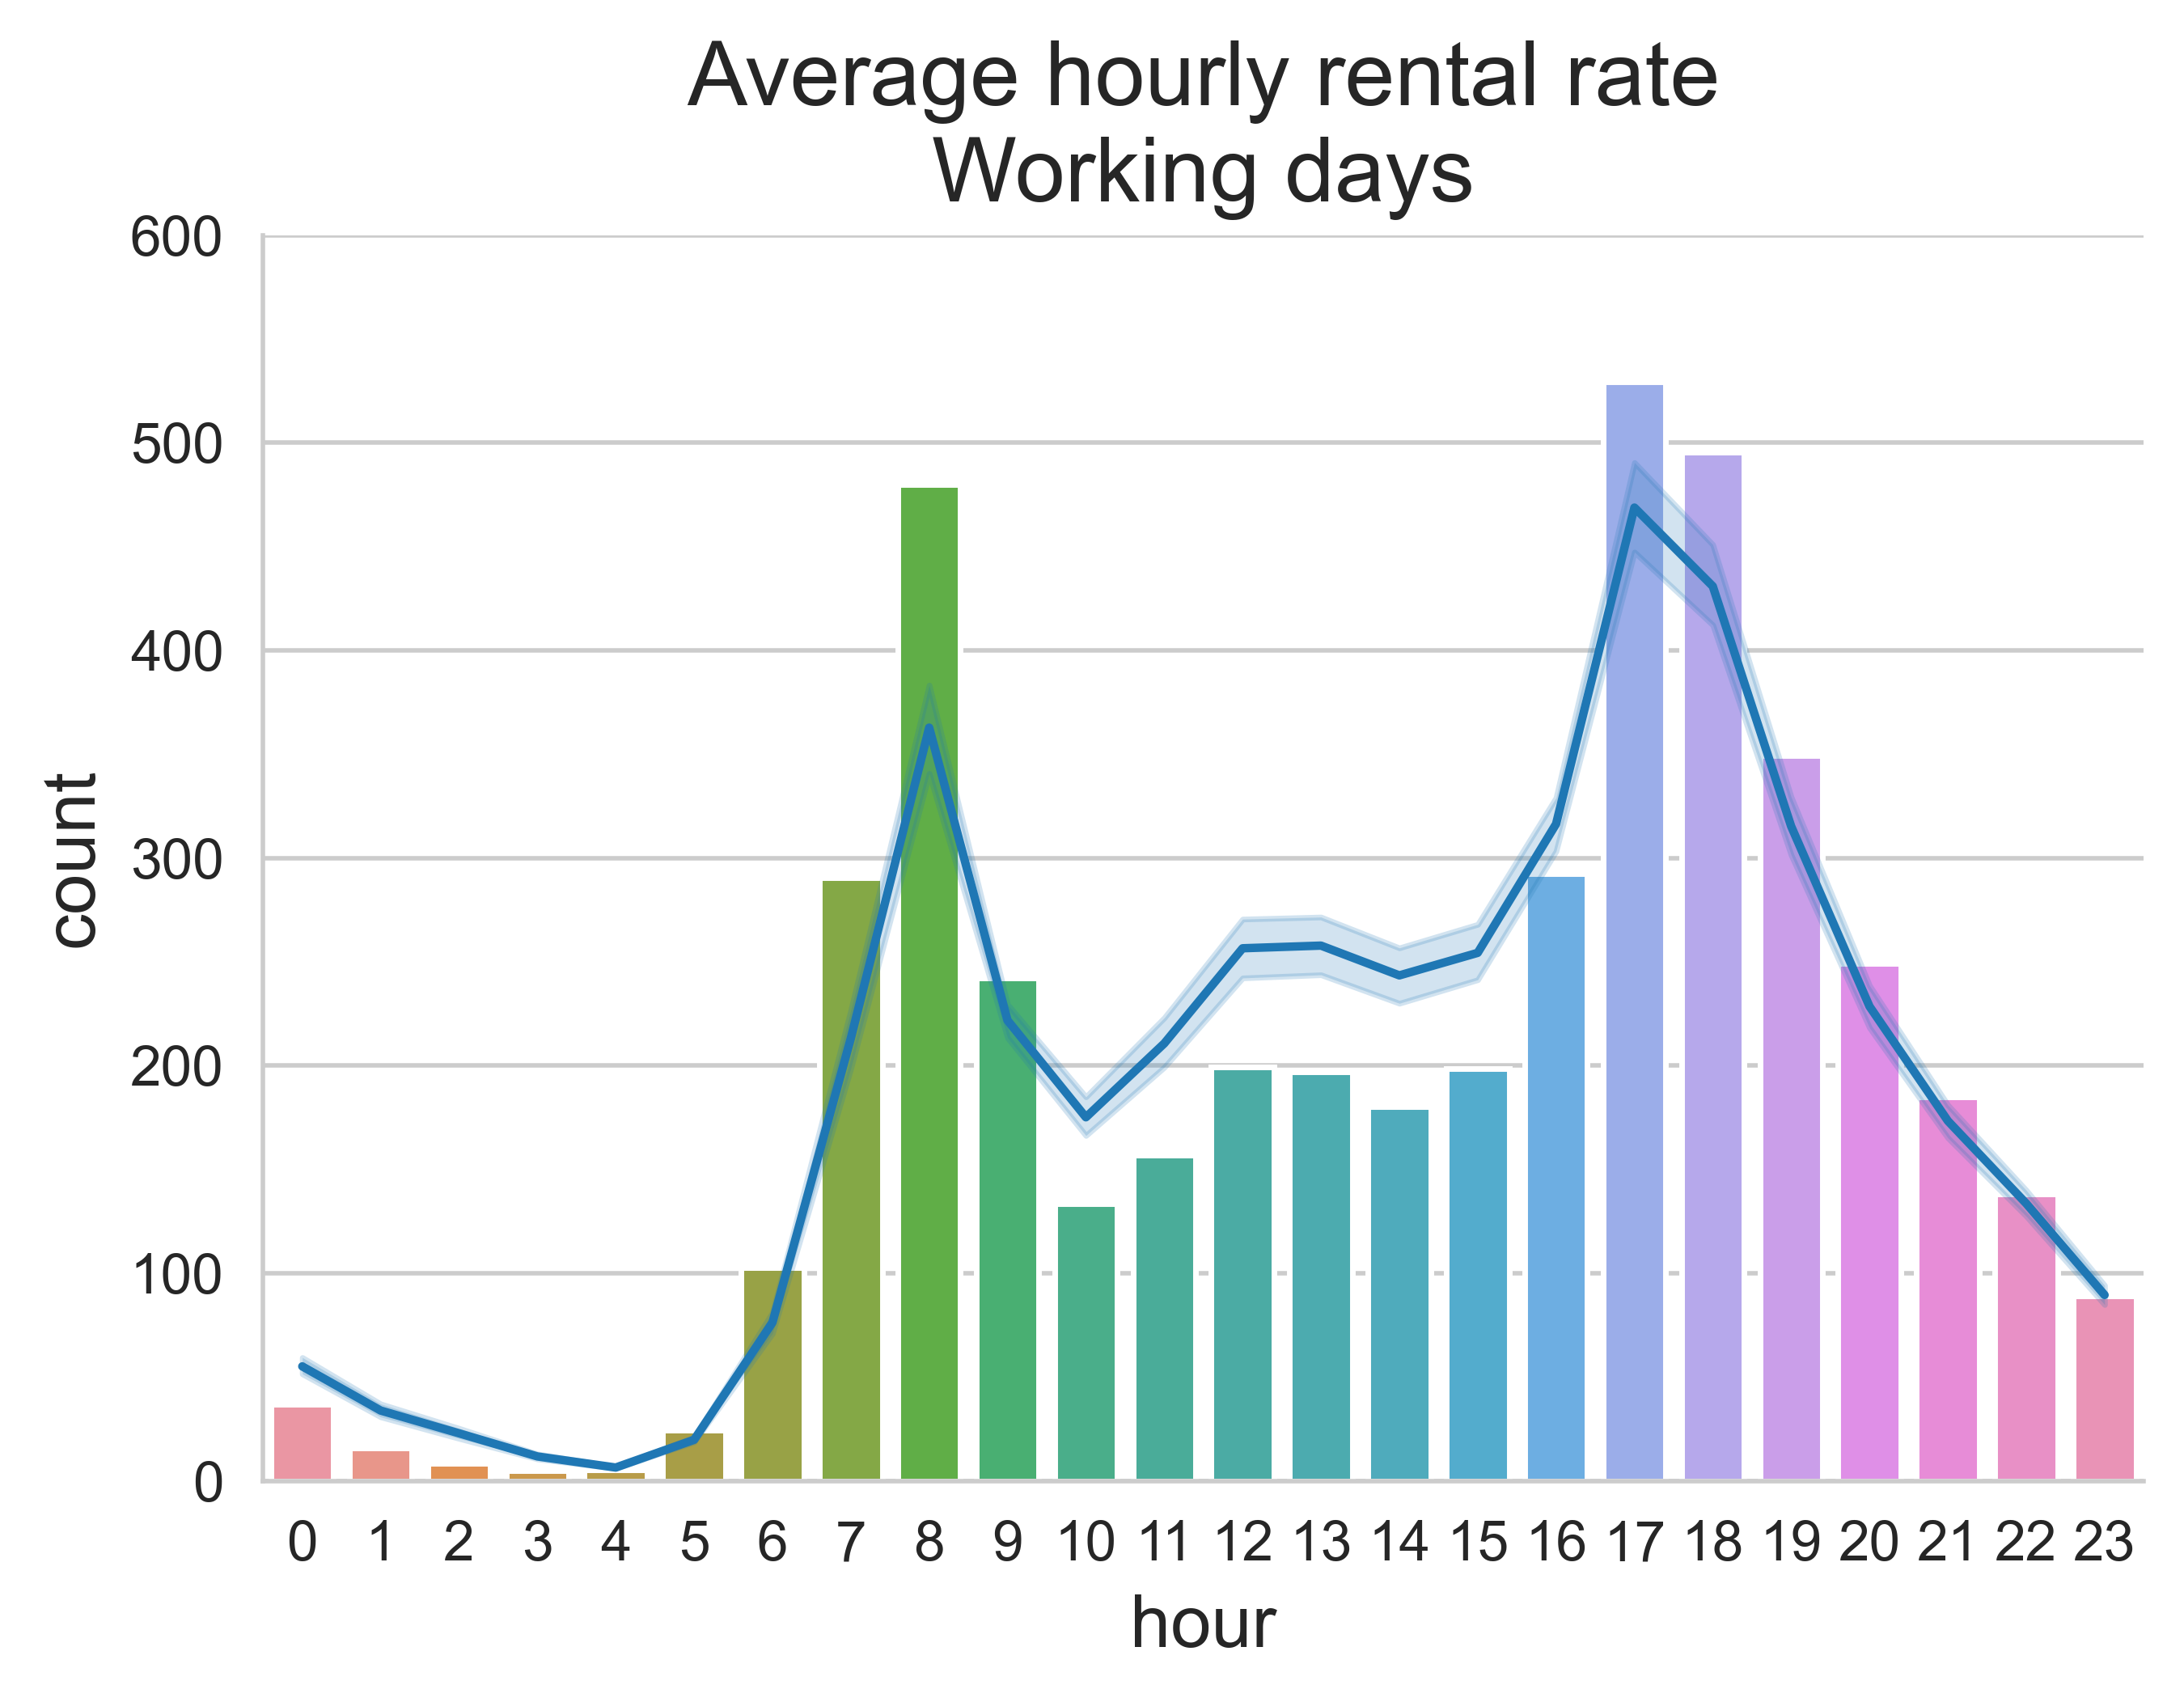

In [590]:
plt.figure(figsize=(6, 4), dpi=500)
plt.title('Average hourly rental rate\nWorking days', fontsize=16)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Number of passengers", fontsize=13)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0,23)

plt.ylim(0,600)

sns.barplot(data=df.loc[df['workingday']=='yes'], x='hour', y='count',estimator='mean', errorbar=None)
sns.lineplot(data=df, x='hour', y='count')
sns.despine()

plt.savefig(fname='AvgHourlyWorkingDays', transparent=True)

plt.show()

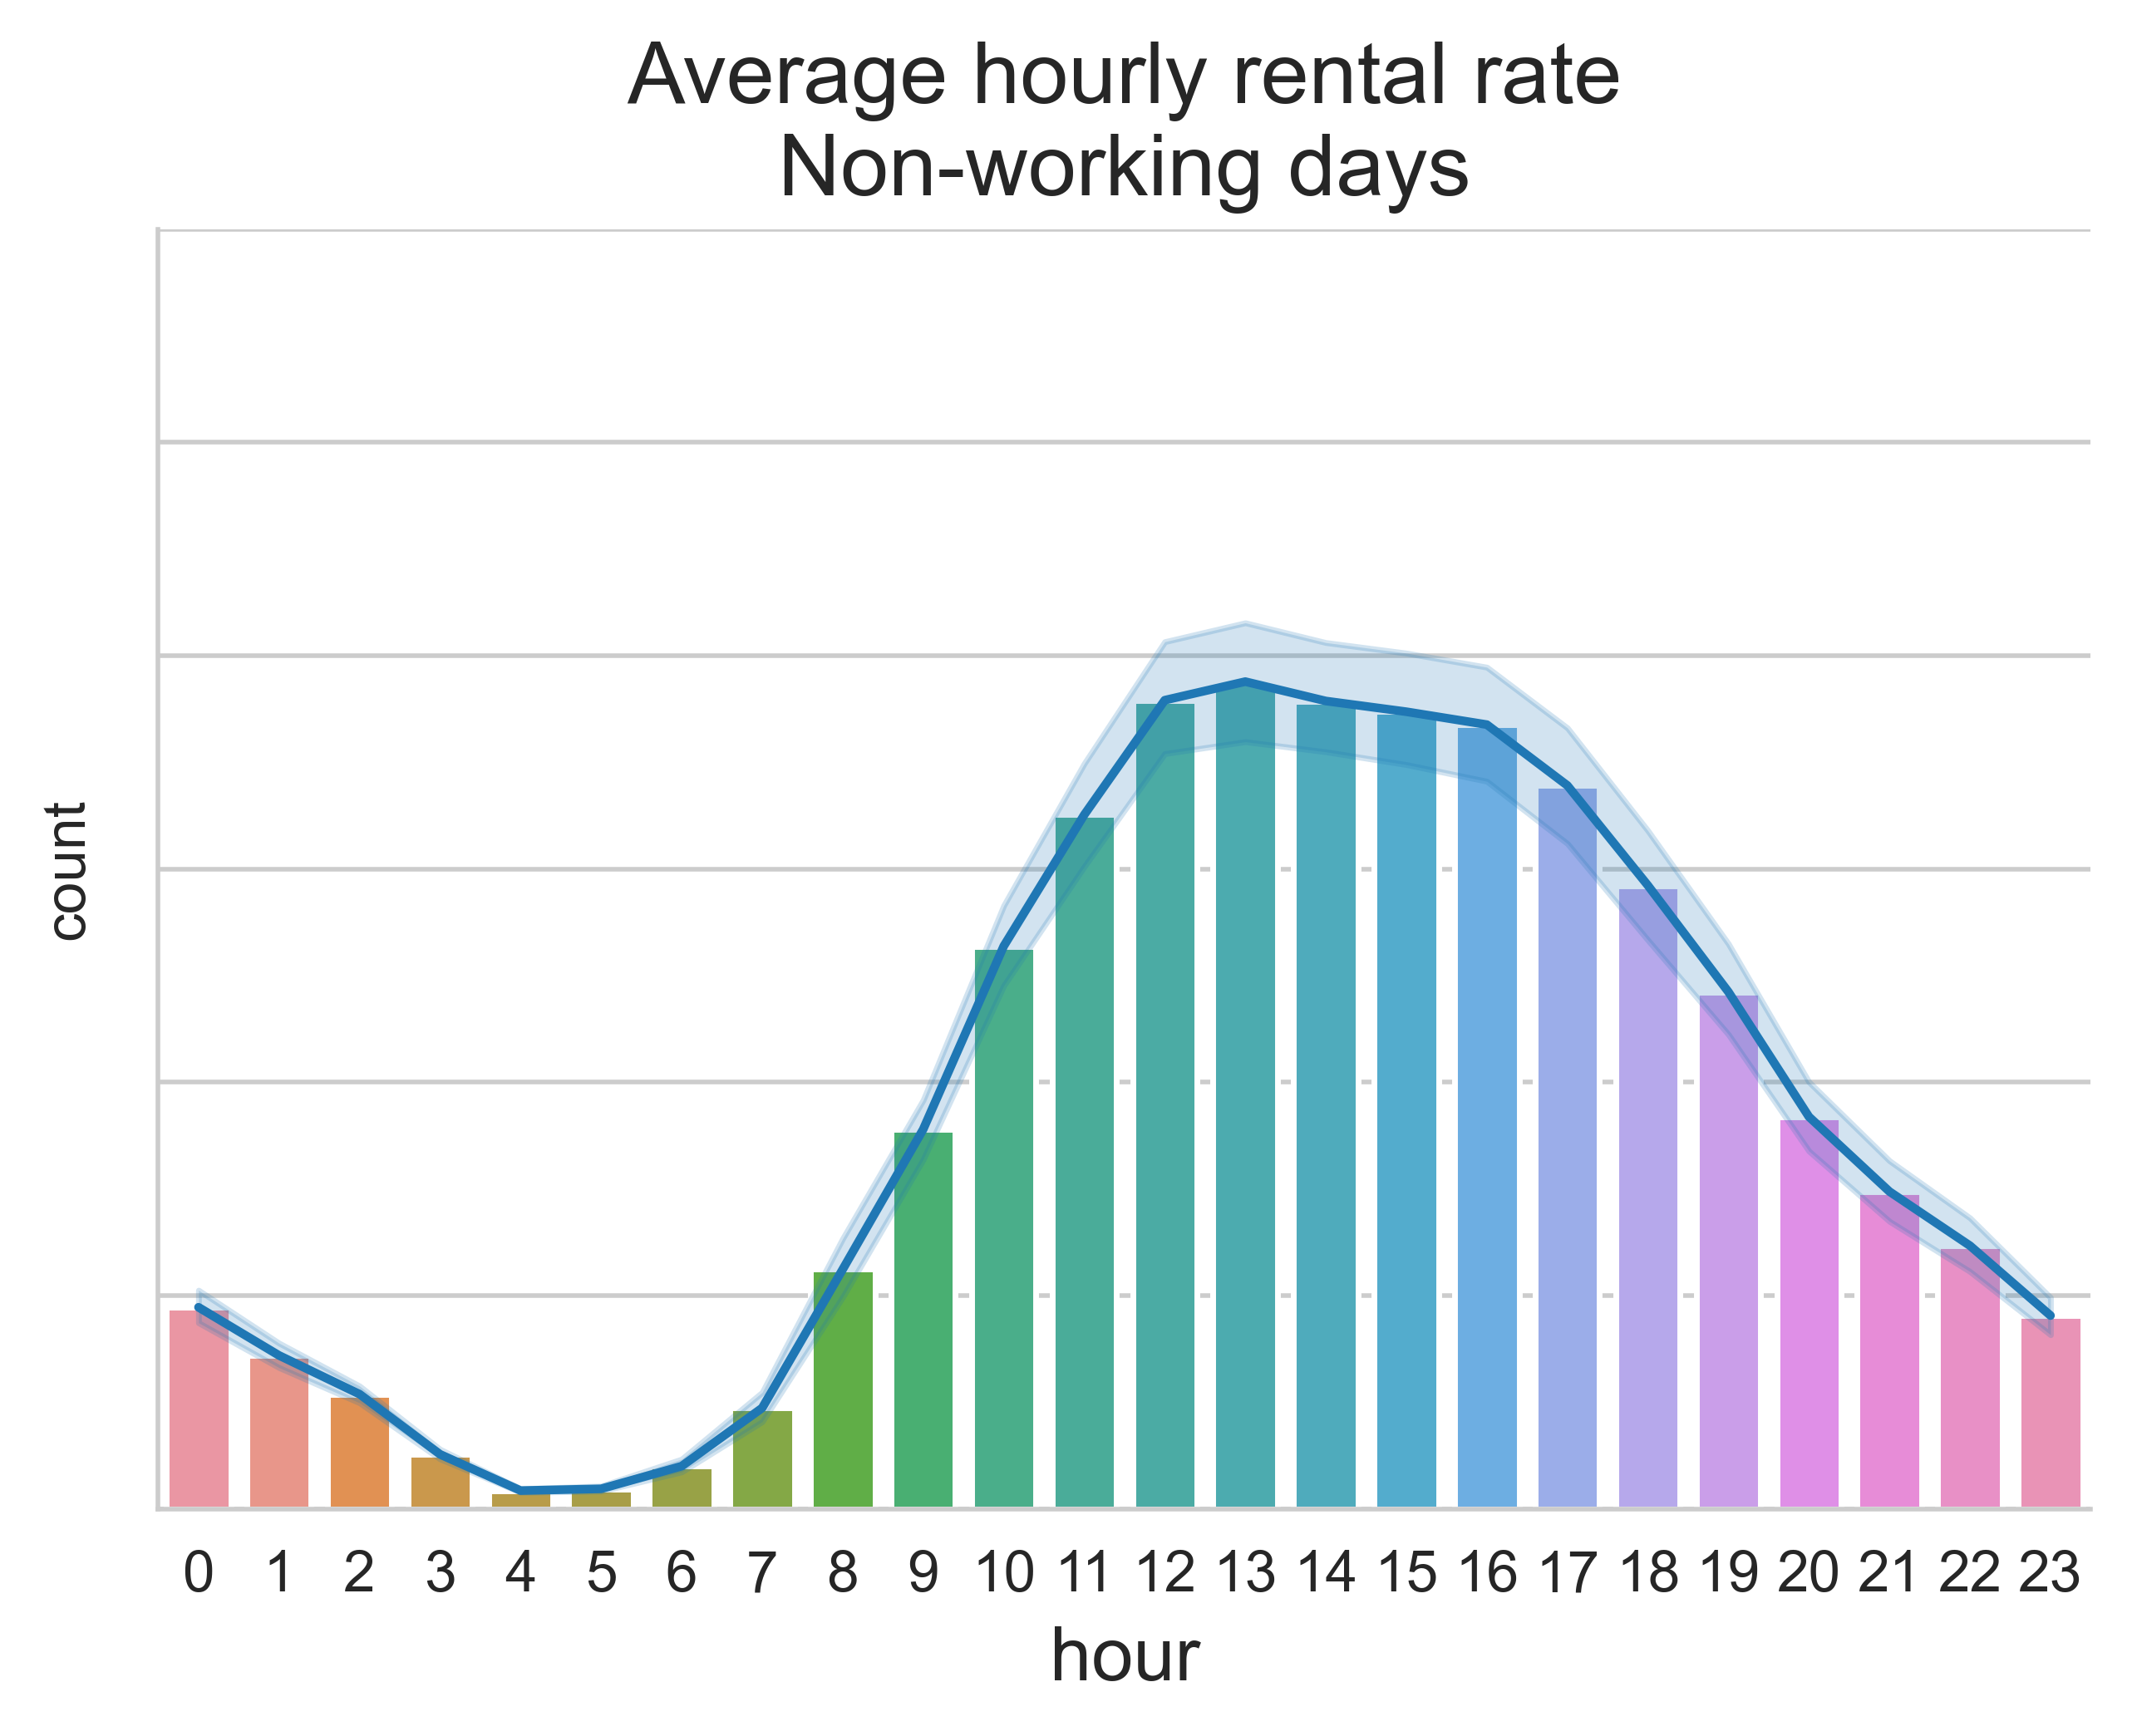

In [608]:
plt.figure(figsize=(6, 4), dpi=500)
plt.title('Average hourly rental rate\nNon-working days', fontsize=15)
plt.xlabel("Date", fontsize=13)
plt.xticks(fontsize=10)
plt.xlim(0, 23)
plt.ylim(0, 600)
sns.barplot(data=df.loc[df['workingday'] == 'no'], x='hour', y='count', estimator='mean', errorbar=None)
sns.lineplot(data=df.loc[df['workingday'] == 'no'], x='hour', y='count')
sns.despine()
plt.gca().axes.get_yaxis().set_ticklabels([])
plt.savefig(fname='AvgHourlyNONWorkingDays', transparent=True)
plt.show()
